# Name entity recognizer

This notebook works through creating a Name Entity Recognizer (NER), showing the entire thinking process (of good and bad decisions) from start to end. 

- It's split into sections, where the first couple ones start at data importing and exploration. 
- The data exploration part ends in producing a "baseline model" - a rough estimate of the performance we could get in NER without a machine learning model - instead by using simple rules created on common sense from the dataset statistics. 
- Further on, we discuss the different ML models we can apply to build the NER, such as using standard feed-forward neural nets, or recurrent, or bi-directional recurrent ones. All of these have been tried and evaluated, but this notebook only shows the best approach among them.
- Once we select the ML approach to go with, we then preprocess the raw data and structure it as needed to be used in the model. This includes creation of word dictionaries, processing of input features and target labels, and splitting dataset in train / dev / test portions.
- The next stage is creating functions for model creation, including processing of pre-trained word embeddings, and the actual model creation.
- Afterwards, the above parts are run sequentially in single notebook cell, and results of the train / validation sets are plotted. We've run this part with different sets of parameters, but to shorten on length, only the best parameter set is shown in this notebook.
- Using the parameter set that has shown best performance on the validation set, we then train a final model on both train + validation parts, and save it to file.

The evaluation in terms of precision, recall, F1-score and support of the final model is part of `nerfunc.py` file in this project, which is run using a method `predict_on_test_set`. Output results of this function are shown in figure `example_nerfunc.png`. 

Some imports and configurations..

In [20]:
# Some imports and settings needed for counting and plotting
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = 12,9
import json
import os

# Imports for numerical data and ML
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import backend as K

## 1. Data import and parsing

It would be nice to have each sentence as a list of tuples, where each tuple would consist the following 4 elements `(<current word>, <part of speech tag>, <chunk tag>, <name entity tag>)`. This list dataset will later be passed to functions to process the input and output data of the model.

In [2]:
def get_dataset(file):
    """
    Read the dataset in `file` line-by-line and return a list of sentences.
    
    :param file: A String containing the path to the text document containing data. 
    
    return: A list of sentences, where each sentence is a list of tuples:
            (<current word>, <part of speech tag>, <chunk tag>, <name entity tag>)
    """
    print("Creating dataset...", end=" ")
    
    dataset = []
    
    with open(file, "r") as file:
    
        sentence = []

        # Read all lines one by one
        for line in file:
            line_items = line.split()

            # Ignore DOCSTART lines
            if 'DOCSTART' in line:
                continue

            # If empty row, add sentence to dataset and re-initialise it
            if len(line_items) == 0:

                if len(sentence) > 0:
                    dataset.append(sentence)
                sentence = []
                continue

            # If row is not empty add word to sentence
            if len(line_items) > 0:
                sentence.append(tuple(line_items))

    print("done.")
    return dataset


In [3]:
# Example use
dataset = get_dataset(file="Datasets/ner_dataset.txt")
print("An example sentence:")
print(dataset[0])

Creating dataset... done.
An example sentence:
[('EU', 'NNP', 'B-NP', 'B-ORG'), ('rejects', 'VBZ', 'B-VP', 'O'), ('German', 'JJ', 'B-NP', 'B-MISC'), ('call', 'NN', 'I-NP', 'O'), ('to', 'TO', 'B-VP', 'O'), ('boycott', 'VB', 'I-VP', 'O'), ('British', 'JJ', 'B-NP', 'B-MISC'), ('lamb', 'NN', 'I-NP', 'O'), ('.', '.', 'O', 'O')]


## 2. Descriptive stats

It's always useful to know more about the data you work with. Here, I'm interested in finding some of the basic statistics on our dataset, like:
- the distribution of sentence length. This could be useful if we need to pad sentences to a fixed length later on;
- the number and names of unique tags in part-of-speech, chunk or name entity tags;
- the number of unique words in the dataset.

In [4]:
# Get the senence lengths in a list
sentence_lengths = [len(sentence) for sentence in dataset]

First, let's see how long the sentences are in our dataset. The following figure shows the histogram of sentence lengths. Labels on top of each bar are added to spot sentences with length > 60.

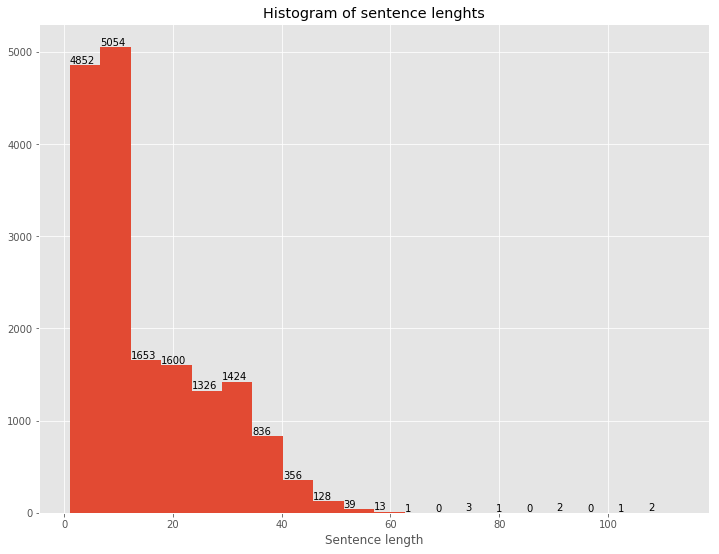

In [21]:
hist_results = plt.hist(sentence_lengths, 20)
for i in range(len(hist_results[0])):
    plt.text(x=hist_results[1][i] , y=hist_results[0][i] + 20, s="%d" % hist_results[0][i], size = 10)
plt.xlabel("Sentence length")
plt.title("Histogram of sentence lenghts")
plt.show()

Second, we can look at the unique name entity tags, and their count. I'll first count the tag appearances and then plot them on a bar plot. The bar plot below shows that we have 4 different name entities in our dataset: Person, Location, Organization and Miscellaneous. Also, most of them are one-word in lenght, shown by the higher numbers for "B-" tags, compared to "I-" tags. Of course, if we only look at the "B-" tags we'd have an accurate number of name entity tags in our dataset, regardless of their word length.

Name entity tags, sorted by number of appearances:
[('O', 212337), ('B-LOC', 8977), ('B-PER', 8442), ('B-ORG', 7662), ('I-PER', 5835), ('I-ORG', 4455), ('B-MISC', 4360), ('I-MISC', 1501), ('I-LOC', 1414)]


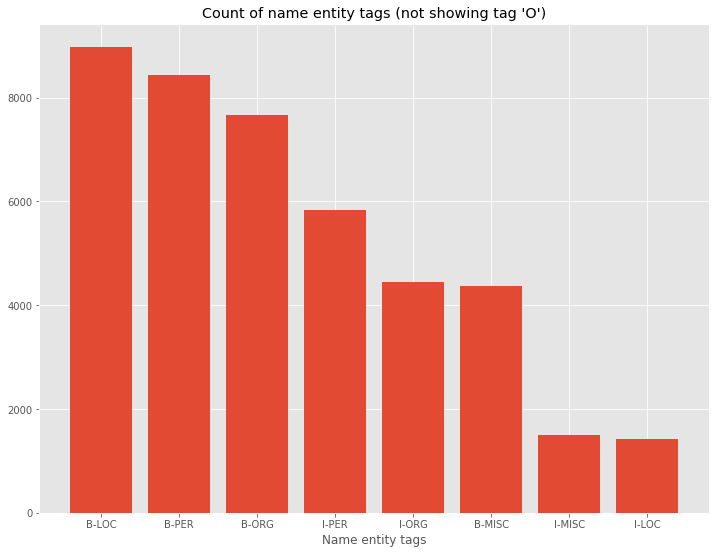

In [22]:
# Count the unique Name Entity Tags
count_NEtags = Counter([row[3] for sentence in dataset for row in sentence])
print("Name entity tags, sorted by number of appearances:")
print(count_NEtags.most_common())

# A quick plot can also help. I'll exclude the 'O' tag here since it's not part of an entity
plt.figure()
tags, counts = zip(*count_NEtags.most_common()[1:])
plt.bar(tags, counts)
plt.xlabel("Name entity tags")
plt.title("Count of name entity tags (not showing tag 'O')")
plt.show()

We can do the same with the part-of-speech and chunk tags. These insights might not be very useful for the model later, but still they can bring in some ideas. 

The results of the two cells below show that noun phrases are the most common ones, and usually they are longer than one-word (higher number of I-NP than B-NP tags). Note that, the meaning of many of the POS tags is unknown to me, but we can still use them in the model. The next section should decide if these tags should be used as input features or not.

In [7]:
count_POStags = Counter([row[1] for sentence in dataset for row in sentence])
print("Part-of-speect tags, sorted by number of appearances:")
print(count_POStags.most_common())

Part-of-speect tags, sorted by number of appearances:
[('NNP', 42950), ('NN', 29925), ('IN', 24041), ('CD', 24000), ('DT', 16974), ('JJ', 14874), ('NNS', 12406), ('VBD', 10523), ('.', 9268), (',', 9240), ('VB', 5371), ('VBN', 5098), ('RB', 4964), ('CC', 4585), ('TO', 4375), ('PRP', 4025), (')', 3546), ('(', 3545), ('VBG', 3285), (':', 3010), ('VBZ', 2937), ('"', 2818), ('POS', 1976), ('PRP$', 1942), ('VBP', 1801), ('MD', 1499), ('NNPS', 850), ('RP', 678), ('WDT', 661), ('WP', 655), ('$', 528), ('SYM', 525), ('JJR', 487), ('WRB', 477), ('JJS', 332), ('RBR', 216), ('FW', 195), ('EX', 176), ('RBS', 53), ("''", 46), ('PDT', 40), ('UH', 35), ('WP$', 32), ('LS', 14), ('NN|SYM', 5)]


In [8]:
count_Chunktags = Counter([row[2] for sentence in dataset for row in sentence])
print("Chunk tags, sorted by number of appearances:")
print(count_Chunktags.most_common())

Chunk tags, sorted by number of appearances:
[('I-NP', 82998), ('B-NP', 72031), ('O', 34618), ('B-PP', 23727), ('B-VP', 22743), ('I-VP', 10989), ('B-ADVP', 3287), ('B-SBAR', 1635), ('B-ADJP', 1471), ('B-PRT', 674), ('I-ADJP', 263), ('I-ADVP', 177), ('I-PP', 120), ('B-INTJ', 90), ('I-CONJP', 52), ('B-CONJP', 41), ('B-LST', 35), ('I-SBAR', 25), ('I-LST', 4), ('I-PRT', 2), ('I-INTJ', 1)]


And finally, I'm interested in the number of unique words in our dataset. Let's just print their count. Please also note that the number of sentences in the dataset, as calculated abobe, is 17291.

In [9]:
word_list = [word[0] for sentence in dataset for word in sentence]
unique_words = set(word_list)
print("Number of sentences: %d." % len(dataset))
print("Number of words: %d." % len(word_list))
print("Number of unique words: %d." % len(unique_words))

Number of sentences: 17291.
Number of words: 254983.
Number of unique words: 26883.


## 3. Baseline model

Before going into the modeling part, it's always useful to have a baseline model to compare with, and we can use the above descriptive stats to think of one.

This model could simply be chosen by looking at the entity tags; Since 'O' tags (referring to NO entity) are much more frequent then other ones, a model predicting only 'O' tags will reach pretty good accuracy. This will be our baseline.

In [10]:
print("Accuracy of baseline model: %.3f %%" % (100 * count_NEtags['O'] / sum(count_NEtags.values())))

Accuracy of baseline model: 83.275 %


## 4. Model - big picture

Here, I'd like to discuss some of the options we have to build a Name Entity Recognizer, and to briefly describe the chosen direction.

There are many approaches that can be helpful in this task, but I'll focus on neural networks, since their use in sequence models is state-of-the-art at the moment. Here are some of the options we have:
    - Standard feed-forward NN. Pad the sentences to a fixed length and plug them in the NN. This approach will not capture relatioship between words and may not work well, but is a good and simple starting point which can be compared to the "baseline model"
    - One-direction recurrent neural network. RNNs using GRU and LSTM are one of the best options to go for in our case. Anyway one-directional ones take into account only the words preceeding a given word in a sentence.
    - Bi-directional RNNs. These networks would use all the words in a sentence to make a prediction for a given word, so they would perform better than the one-directional ones, but at a cost of computational complexity. Furthermore, they bring huge benefits in NLP (which is not the case for any sequence based task).
    
<b>Important</b>: I would skip the feed-forward NN case because it's too simplistic. Then, choosing between a one-directional and bi-directional RNN is a question of our use case. Do we expect that we'll have the whole sentence before making a prediction, or we need to make a prediction as the sentence is written? In this case, knowing Util's usecases I'll assume that we have the whole sentence available.

Note also that in using TensorFlow or Keras, sentences need to be padded, while if using PyTorch, because of its Dynamic Computational Graph, we could use sentences as they originally are. Anyway, padding wouldn't hurt the performance of the model.

## 5. Data preprocessing

The following figure describes the mapping of inputs to targets in an RNN network. 

A text sentence would represent our input, and words ("tokens") are plugged in the RNN one by one as in the figure. Each word should be mapped to a vector which denotes one of the target categories: Person, Location, Organization, Miscellaneous, and Other.

<b>Inputs</b>

Words must first be encoded into numbers, and the best way to do it is using a pre-trained "word embeddings". In this case I'll use the [GloVe 100D embeddings](https://nlp.stanford.edu/projects/glove/). Other options for the encoding would be One-Hot encodings and self-learned word embeddings, but these approaches have worse performance.

<b>Outputs</b>

Each input token can be mapped to an output vector: `[<person>, <location>, <organization>, <misc>, <no-entity>]`, which is One-hot like i.e. only one of the elements can be 1, while the rest are zeros. Note that if we wanted to also detect the start/non-start of each NE tag, we could use an output vector like `[<B-person>, <I-person>, <B-location>, <I-location>, <B-organization>, <I-organization>, <B-misc>, <I-misc>, <no-entity>]`, but this approach would need more data to be trained on (since we have more output classes), and it may result in worse performance.

![Example of Recurrent NN with many-to-many architecture](figures/rnn_2.png)

### Word dictionaries

It would be handy to create a `word_index` - a Python dictionary for mapping each word from String to integer representation. Also a `reverse_word_index` could be useful, doing the opposite. The following function uses the downloaded GloVe vectors to create the mapping dictionaries.

<b>Important</b>: The GloVe word embeddings used here have 400000 unique words, each 100-dimensional. Anyway, we don't have to use this big vocabulary for the task, and we could have used the `dataset`'s unique words (around 17000) to do the mapping. So why did I choose GloVe? This is because when we use the trained model to work with new data, some of the words may be unknown to the model, but if we use GloVe it is unlikely to happen. Of course this comes at the price of increased complexity.

In [11]:
def create_mapping_dicts():
    """
    Create dictionaries to map between word strings and word numbers.
    
    return: A tuple of Python dictionaries mapping: 
    (1) words to numeric indices, (2) numeric indices to words
    """
    
    print("Creating mapping dictionaries...", end =" ")
    
    glove_dir = 'Datasets/glove.6B'

    word_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
    for i, line in enumerate(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        word_index[word] = i
    f.close()
    
    reverse_word_index = {j: i for i, j in word_index.items()}
        
    print("done.")
    return word_index, reverse_word_index

In [12]:
# Print the first 10 words in our dictionaries
word_index, reverse_word_index = create_mapping_dicts()
print([reverse_word_index.get(i) for i in range(10)])

Creating mapping dictionaries... done.
['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]


### Preprocess outputs

As mentioned earlier, each input token would be mapped to a 5D One-hot vector `[<person>, <location>, <organization>, <misc>, <no-entity>]`. The following function processes the NE tags to create these vectors. Also it would be nice to have the dimension of the output vector as a global constant `OUTPUT_DIMENSION`.

In [13]:
OUTPUT_DIMENSION = 5
MAX_SENTENCE_LENGTH = 60

def preprocess_outputs(dataset):
    """
    Creates a targets matrix of shape (NUM_SENTENCES, MAX_SENTENCE_LENGTH, OUTPUT_DIMENSION)
    
    :param dataset: A list of tuples (<current word>, <part of speech tag>, <chunk tag>, <name entity tag>)
    containing the whole data in our dataset
    
    returns: A numpy 3D matrix for the model's `targets` 
    """
    
    print("Building output data (targets)...", end=" ")
    
    NUM_SENTENCES = len(dataset)

    # Initialise targets to zeros
    targets = np.zeros((NUM_SENTENCES, MAX_SENTENCE_LENGTH, OUTPUT_DIMENSION))

    # Loop over each sentence in the dataset, and each word in sentences
    for j, sentence in enumerate(dataset):
        for i, word in enumerate(sentence):

            # Only add the first MAX_SENTENCE_LENGTH words
            if i < MAX_SENTENCE_LENGTH:

                # Assign a target output for each word in the sentence
                label = word[3]
                if 'PER' in label:
                    targets[j, i, :] = [1, 0, 0, 0, 0]
                elif 'ORG' in label:
                    targets[j, i, :] = [0, 1, 0, 0, 0]
                elif 'LOC' in label:
                    targets[j, i, :] = [0, 0, 1, 0, 0]
                elif 'MISC' in label:
                    targets[j, i, :] = [0, 0, 0, 1, 0]
                elif label == 'O':
                    targets[j, i, :] = [0, 0, 0, 0, 1]
                else:
                    targets[j, i, :] = [0, 0, 0, 0, 0]
                   
    print("done.")
    return targets

### Preprocess inputs

Now we can create the `inputs` variable containing our training sentences in the format that we need. That is, represent each of the words in our dataset with a numeric number, as defined with the `create_mapping_dicts` function above. Since I'm using Keras, sentences must be padded to a maximum sentence length of MAX_SENTENCE_LENGTH.

In [14]:
def preprocess_inputs(dataset_, word_index):
    """
    Loops through all words in all sentences and: 
    (1) converts them to indices
    (2) adds padding to a length of MAX_SENTENCE_LENGTH
    
    :param dataset_: A list of tuples (<current word>, <part of speech tag>, <chunk tag>, <name entity tag>)
    containing the whole data in our dataset
    :param word_index: A dictionary with (<word>, <integer number>) (key, value) pairs
    
    return: A numpy matrix for the inputs with shape (NUM_SENTENCES, MAX_SENTENCE_LENGTH)
    """

    print("Building input data...", end=" ")
    
    # initialise a list for the input data
    inputs = []

    # Loop through sentences
    for i, sentence in enumerate(dataset_):
        sentence = [word[0] for word in sentence]
        input_ = []
        
        # Loop through words in sentence
        for word in sentence:
            word = word.lower()
            word_num = word_index.get(word)
            if word_num is None:
                word_num = word_index.get('unk')
            input_.append(word_num)
        inputs.append(input_)

    # Pad sentences to some maximum length. Padding and truncation is done at the back of the sentence
    inputs = pad_sequences(inputs, maxlen=MAX_SENTENCE_LENGTH, padding='post', truncating='post')
    
    print("done.")
    return inputs

In [15]:
MAX_SENTENCE_LENGTH = 60
inputs = preprocess_inputs(dataset, word_index)

Building input data... done.


### Split datasets

Finally we can split our `inputs` and `outputs` into Train / Dev / Test sets. Later on we can train our model on the Train set and validate it on the Dev one in an iterative process, until we're satisfied with the model's performance. A final test can be done on the Test set.

In [16]:
def split_datasets(inputs_, targets_, shuffle=True):
    """
    Splits the inputs and targets into Train / Dev / Test subsets
    
    :param inputs_: A numpy matrix with input data
    :param targets_: A numpy matrix with targets data
    :param shuffle: A boolean value denoting if data should be shuffled
    
    returns: A tuple of numpy matrices as follows:
    (train_x, train_y), (dev_x, dev_y), (test_x, test_y)
    """
    
    print("Splitting datasets...", end=" ")
    
    num_samples = len(inputs_)
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
        
    train_x = inputs_[:int(0.7 * num_samples)]
    train_y = targets_[:int(0.7 * num_samples)]
    
    dev_x = inputs_[int(0.7 * num_samples) : int(0.85 * num_samples)]
    dev_y = targets_[int(0.7 * num_samples) : int(0.85 * num_samples)]
    
    test_x = inputs_[int(0.85 * num_samples):]
    test_y = targets_[int(0.85 * num_samples):]
    
    print("done.")    
    return (train_x, train_y), (dev_x, dev_y), (test_x, test_y)

## 6. Modeling

We now have all the data ready to be plugged in an ML model. Here we define a function for creating the "word embedding" matrix and the function for creation of a model and its training.

### Word embeddings

Create a dictionary `embeddings_index` that would map words to their 100D embedding, retreived from the pretrained GloVe word embeddings. Then create an embedding matrix with shape `(<number of words in GloVe embedding>, EMBEDDING_DIM)` that would map words from our dataset into their 100D encoding.

<b>Important</b>: Again I'd like to note that the big Embedding matrix in this step is needed so the model can work with new (unseen) words. Since the matrix here is pretty big, when we save it to file later on, it might be above 100MB on disk. A more optimal approach would be to use another source of the, let's say 50000 most used words in English, and then build the embedding matrix as (50000, 100).

In [17]:
def create_embeddings():
    """
    Create an embedding matrix of shape (400000, 100), and an embedding index for mapping words to vectors,
    using the pre-trained GloVe vectors downloaded from: https://nlp.stanford.edu/projects/glove/.
    
    returns: A tuple of:
        - The embedding matrix - a numpy array of shape (400000, 100)
        - The embedding index - a dictionary for the mapping of a word to an embedding vector. 
        The dict has (word, vector) as (key, value) pairs.
    """
    
    print("Creating word embeddings...", end=" ")
    
    # Create `embedding_index` dictionary to map words to encodings
    glove_dir = 'Datasets/glove.6B'

    emb_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        emb_index[word] = coefs
    f.close()
    
    # Initilise the Embedding matrix
    emb_matrix = np.zeros((len(emb_index), len(emb_index.get('a'))))

    # Loop through all words in our dataset and get the embedding for each
    for i, word in enumerate(emb_index.keys()):
        emb_vector = emb_index.get(word)
        emb_matrix[i] = emb_vector
            
    print("done.")
    return emb_matrix, emb_index

### Create and train model

The following method creates an RNN model and trains it. As result, it returns the trained model and the training history.

The model contains:
- An embedding layer in which the pre-trained matrix is plugged in. It maps words into embedding vectors.
- A bidirectional layer of LSTM cells. The LSTM cells have 128 hidden layers and each returns outputs, so we can have a predicted output for each word in a sentence.
- A dropout layer for adding regularization - to fight overfitting. We could also add in recurrent_dropout later on if needed.
- A Dense layer where the outputs of the LSTM and Dropout get fully connected in 5 nodes - each making a decision for one value of the 5D output, as described in Section 5.
- A softmax activation to output the 5 values as probabilities i.e., they sum up to 1.

In the `compile` method I've chosen 'adam' optimizer as one of the best ones known. I would change it if after many Train-Validation iterations I see that the loss gets stuck in a local minimum. Then a different optimizer may help in reaching a better optimum.

For the `loss` function I use `categorical_crossentropy`. This is because we're doing a multi-class classification, and this loss would calculate the "distance" between actual and predicted values for each class, and then calculates their average. This is what needs to be minimised. <b>Important</b>: Since our dataset is skewed, with "O" tags taking 83% of the words, we can use a "weighted loss" where more importance is given to correctly classifying the other classes. A starting point for this is in the following [link](https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d).

Finally, the metric to be observed here is chosen as "accuracy". <font color="red">Anyway, this value for the accuracy in our case is not correct. This is because of adding padding to sentences - which then are calculated as "wrong classifications", but actually they should be ignored.</font> One way to fix this is mentioned in Section 9, using a custom made metric. I didn't have enough time to make it work, but my draft code is given there.

One last thing.. In the train / validation iterations I would change the number of epochs, batch_size (to optimise for speed) and then look at the resulting plot for the loss. The next step would be to play with the dropout parameter, and possibly changing the 'optimizer'.

In [33]:
def create_train_model(train_samples, dev_samples, embedding_matrix, dropout=0, epochs=20):
    """
    Creates and trains an RNN model.
    
    :param train_samples: A tuple of two numpy matrices for the:
        - inputs; with shape (<num samples>, MAX_SENTENCE_WIDTH)
        - outputs; with shape (<num samples>, MAX_SENTENCE_WIDTH, OUTPUT_DIMENSION)
        
    :param dev_samples: A tuple of two numpy matrices for the validation inputs and outpus
    :param embedding_matrix: A numpy matrix with the word embeddings in the Glove dictionary
    :param dropout: A float value denoting the regularization parameter
    :param epochs: An integer denoting the number of training epochs
    
    return: A tuple of (A keras model, model training history)
    """
    
    print("Creating model...")
    
    input_layer = layers.Input(shape=(MAX_SENTENCE_LENGTH, ))
    X = layers.Embedding(400000, 100, input_length=MAX_SENTENCE_LENGTH)(input_layer)
    X = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(X)
    X = layers.Dropout(dropout)(X)
    X = layers.Dense(5)(X)
    X = layers.Activation('softmax')(X)
    model = models.Model(inputs=input_layer, outputs=X)

    # Plug the embedding matrix in the model's Embedding layer
    model.layers[1].set_weights([embedding_matrix])
    model.layers[1].trainable = False
    
    model.summary()

    # Compile the model, choosing an optimizer and a loss function to be minimised
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    print("Training model...")
    history = model.fit(train_samples[0], train_samples[1], epochs=epochs, batch_size=128, validation_data=dev_samples)
    
    return model, history

### Plotting

We can use the following function to plot the results of training.

In [40]:
def plot_history(history):
    """
    Plots the history of model training - its loss and accuracy.

    :param history: A keras history object, as retrieved from the `fit` method 
    
    return: /
    """
    
    # Retrieve values to be plotted from the `history` object
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    # Figure 1: loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss [sentence length: %d]' % MAX_SENTENCE_LENGTH)
    plt.legend()
    
    # Figure 2: accuracy
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy [sentence length: %d]' % MAX_SENTENCE_LENGTH)
    plt.legend()

    plt.show()

## 7. Putting everything together

Finally we can take all the pieces defined above and put them together in the following cell. Here, I've run many iterations in order to find a suitable set of parameters that would provide a nice model, while I only present the latest result.

In [39]:
# Set some parameters
MAX_SENTENCE_LENGTH = 60
OUTPUT_DIMENSION = 5
filepath = "Datasets/ner_dataset.txt"

# Create dataset
dataset = get_dataset(filepath)
# NUM_SENTENCES = len(dataset)

# Create mapping dicts for word to number and vice versa
word_index, reverse_word_index = create_mapping_dicts()

# Process output labels
targets = preprocess_outputs(dataset)

# Process input data
inputs = preprocess_inputs(dataset, word_index)

# Split dataset 
(train_x, train_y), (dev_x, dev_y), (test_x, test_y) = split_datasets(inputs, targets, shuffle=True)

# Create embedding matrix using GloVe vectors
emb_matrix, _ = create_embeddings()

# Create and train model
model, history = create_train_model(train_samples=(train_x, train_y),
                                    dev_samples=(dev_x, dev_y),
                                    embedding_matrix=emb_matrix,
                                    dropout=0.5, 
                                    epochs=50)

Creating dataset... done.
Creating mapping dictionaries... done.
Building output data (targets)... done.
Building input data... done.
Splitting datasets... done.
Creating word embeddings... done.
Creating model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 60, 100)           40000000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 60, 256)           234496    
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 60, 5)             1285      
____________________________________________________________

The following plot shows the training and validation curves of the model. At around 15th epoch, it starts overfitting, even if I included pretty high regularization with dropout = 0.5. Here it would be beneficial to also play with the "recurrent dropout" parameter, but since training models takes a lot of time on my computer, I will not do it at this moment. Since the  validation loss has a minimum at the around 15th epoch, I can run the model for 15 epochs and that would be our final model. This is done in the next-next cell.

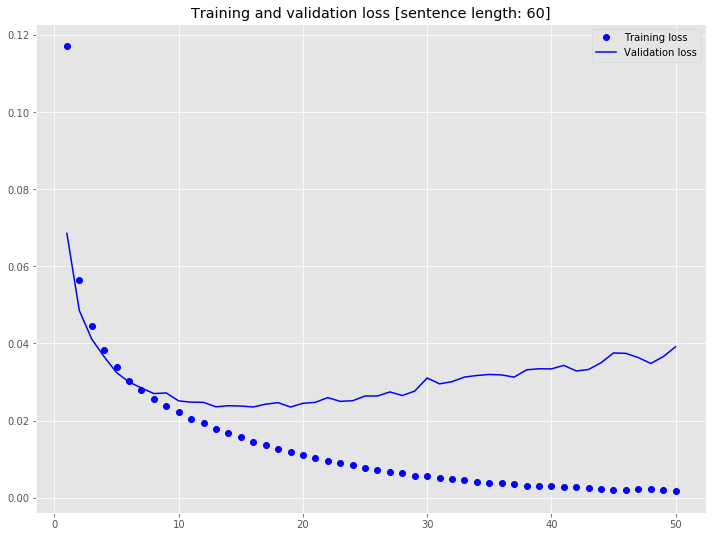

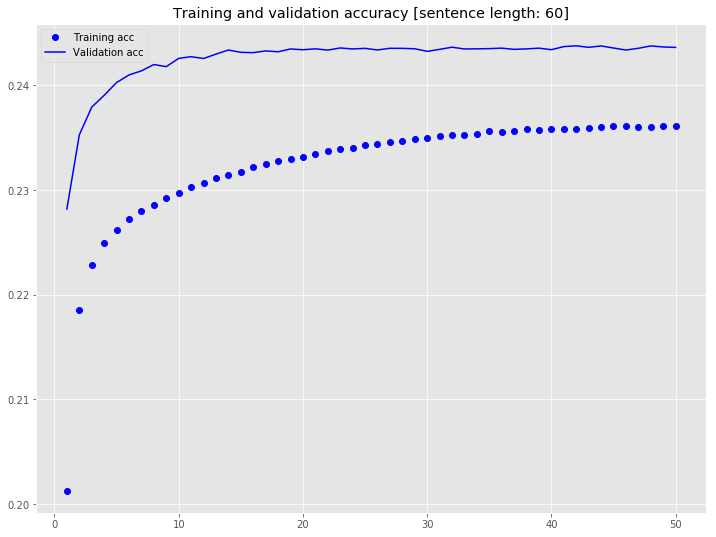

In [41]:
# Plot results of training
plot_history(history)

### Train final model

In [42]:
# Create and train model
model, history = create_train_model(train_samples=(train_x, train_y),
                                    dev_samples=(dev_x, dev_y),
                                    embedding_matrix=emb_matrix,
                                    dropout=0.5, 
                                    epochs=15)

Creating model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 60, 100)           40000000  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 60, 256)           234496    
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 60, 5)             1285      
_________________________________________________________________
activation_9 (Activation)    (None, 60, 5)             0         
Total params: 40,235,781
Trainable params: 235,781
Non-trainable params: 40,000,000
________________________________________

Once we have our final model trained, it should be saved to file, so we can simply load it and do predictions when needed. The Python script `nerfunc.py` that contains the `predict_on_test_set` and `predict_on_texts` works in this way. Let's save the model and the `word_index`.

In [43]:
def save_to_file(model, word_index):
    model.save('ner_trained_model.h5')

    with open('word_index.json', 'w') as file:
        json.dump(word_index, file)

save_to_file(model, word_index)

## 8. Evaluation

The main scripts for evaluating the model, including the `predict_on_test_set` and `predict_on_texts` functions, are in the `nerfunc.py` file, and they provide more detailed result. Here, I'll calculate the loss function on the test set, in order to compare it with the previously obtained losses of the training and validation. 

In [45]:
loss, _ = model.evaluate(test_x, test_y)
print("Test loss:", loss)

2594/2594 [==============================] - 3s 1ms/step
Test loss: 0.02619291790804137


Ok, so our test loss is close to the validation one, meaning we didn't do much overfitting to the Dev set. In the following cell I'll print out the sentences in the test set, together with a tuple (`<target tag>, <predicted tag>`).

In [47]:
def print_predictions(model, test_data):
    
    class_map = {
        0: 'PER',
        1: 'ORG',
        2: 'LOC',
        3: 'MISC',
        4: 'O'
    }
    
    test_x = test_data[0]
    test_y = test_data[1]
    
    preds = model.predict(test_x)
    
    for pred_sample, target_sample, input_sample in zip(preds, test_y, test_x):
       
        # Filter out padding
        valid_indices = np.where(np.sum(target_sample == [0, 0, 0, 0, 0], axis=1) == OUTPUT_DIMENSION - 1)
        pred_outputs = np.argmax(pred_sample[valid_indices], axis=1)
        target_outputs = np.argmax(target_sample[valid_indices], axis=1)
        inputs_valid = input_sample[valid_indices]
        
        # Print actual sentences, targets, and predicted targets in format: 
        # <word> (<target>, <pred_target>) ...
        for i, (target_output, pred_output, word) in enumerate(zip(target_outputs, pred_outputs, inputs_valid)):
            print(reverse_word_index.get(word), end=' ')
            print("(", end='')
            print(class_map[target_output], end=',')
            print(class_map[pred_output], end='')
            print(")", end=' ')
        print()
        print("-" * 30)

print_predictions(model, (test_x, test_y))

from (O,O) january (O,O) to (O,O) june (O,O) unk (ORG,O) exported (O,O) 59 (O,O) percent (O,O) of (O,O) its (O,O) output (O,O) , (O,O) up (O,O) from (O,O) 37.3 (O,O) percent (O,O) in (O,O) the (O,O) same (O,O) period (O,O) last (O,O) year (O,O) . (O,O) 
------------------------------
the (O,O) company (O,O) said (O,O) higher (O,O) than (O,O) anticipated (O,O) inflation (O,O) and (O,O) rising (O,O) raw (O,O) materials (O,O) and (O,O) wage (O,O) costs (O,O) also (O,O) hit (O,O) profits (O,O) . (O,O) 
------------------------------
year-on-year (O,O) inflation (O,O) , (O,O) initially (O,O) estimated (O,O) at (O,O) 20 (O,O) percent (O,O) in (O,O) december (O,O) , (O,O) was (O,O) 33.8 (O,O) percent (O,O) in (O,O) june (O,O) , (O,O) higher (O,O) than (O,O) a (O,O) revised (O,O) unk (O,O) forecast (O,O) of (O,O) 30 (O,O) percent (O,O) . (O,O) 
------------------------------
the (O,O) 12 (O,O) month (O,O) figure (O,O) quickened (O,O) to (O,O) 40.3 (O,O) percent (O,O) in (O,O) july (O,O) . (O,O

primary (O,O) dealers (O,O) immediately (O,O) sold (O,O) eurodollar (MISC,O) and (O,O) bond (O,O) futures (O,O) , (O,O) after (O,O) the (O,O) market (O,O) on (O,O) average (O,O) was (O,O) expecting (O,O) the (O,O) index (O,O) to (O,O) rise (O,O) marginally (O,O) to (O,O) 51.9 (O,O) from (O,O) july (O,O) 's (O,O) 51.2 (O,O) . (O,O) 
------------------------------
traders (O,O) also (O,O) said (O,O) japanese (MISC,MISC) investors (O,O) were (O,O) unwinding (O,O) long (O,O) eurodollar (MISC,O) futures (O,O) / (O,O) short (O,O) swaps (O,O) , (O,O) and (O,O) that (O,O) heavy (O,O) put (O,O) buying (O,O) helped (O,O) pressure (O,O) eurodollars (MISC,O) to (O,O) lower (O,O) levels (O,O) before (O,O) the (O,O) close (O,O) . (O,O) 
------------------------------
one (O,O) u.s. (LOC,LOC) firm (O,O) bought (O,O) 35,000 (O,O) september (O,O) 97 (O,O) unk (O,O) put (O,O) options (O,O) at (O,O) a (O,O) strike (O,O) price (O,O) of (O,O) 93.25 (O,O) to (O,O) 93.30 (O,O) in (O,O) the (O,O) last (O,O) t

trade (O,O) was (O,O) very (O,O) quiet (O,O) with (O,O) only (O,O) one (O,O) deal (O,O) reported (O,O) when (O,O) spot (O,O) high (O,O) protein (O,O) soymeal (O,O) fetched (O,O) 215 (O,O) stg (O,O) a (O,O) tonne (O,O) unk (O,O) on (O,O) the (O,O) south (O,LOC) coast (O,LOC) . (O,O) 
------------------------------
" (O,O) i (O,O) would (O,O) n't (O,O) get (O,O) too (O,O) excited (O,O) about (O,O) this (O,O) one (O,O) becuase (O,O) i (O,O) think (O,O) it (O,O) 's (O,O) for (O,O) all (O,O) of (O,O) five (O,O) tonnes (O,O) , (O,O) which (O,O) when (O,O) you (O,O) think (O,O) about (O,O) just (O,O) about (O,O) sums (O,O) up (O,O) the (O,O) state (O,O) of (O,O) the (O,O) market (O,O) at (O,O) the (O,O) moment (O,O) , (O,O) " (O,O) said (O,O) a (O,O) trader (O,O) . (O,O) 
------------------------------
-- (O,O) jim (PER,PER) ballantyne (PER,PER) , (O,O) london (ORG,ORG) newsroom (ORG,ORG) +44 (O,O) 171 (O,O) 542 (O,O) unk (O,O) 
------------------------------
iraqi (MISC,MISC) captors (O,O) o

" (O,O) i (O,O) never (O,O) wanted (O,O) to (O,O) end (O,O) like (O,O) this (O,O) but (O,O) at (O,O) the (O,O) end (O,O) of (O,O) the (O,O) day (O,O) i (O,O) 'm (O,O) glad (O,O) i (O,O) had (O,O) a (O,O) good (O,O) innings (O,O) . (O,O) " (O,O) 
------------------------------
bruno (PER,PER) , (O,O) for (O,O) years (O,O) one (O,O) of (O,O) britain (LOC,LOC) 's (O,O) most (O,O) popular (O,O) sportsmen (O,O) , (O,O) had (O,O) hoped (O,O) to (O,O) have (O,O) another (O,O) shot (O,O) at (O,O) the (O,O) world (O,O) title (O,O) and (O,O) had (O,O) been (O,O) in (O,O) training (O,O) until (O,O) a (O,O) routine (O,O) eye (O,O) test (O,O) on (O,O) monday (O,O) highlighted (O,O) a (O,O) problem (O,O) with (O,O) his (O,O) right (O,O) eye (O,O) . (O,O) 
------------------------------
professor (O,O) david (PER,PER) mcleod (PER,PER) , (O,O) who (O,O) examined (O,O) bruno (PER,PER) , (O,O) told (O,O) the (O,O) sun (ORG,ORG) : (O,O) " (O,O) there (O,O) is (O,O) a (O,O) risk (O,O) he (O,O) could (O,O)

but (O,O) russia (LOC,LOC) failed (O,O) to (O,O) win (O,O) control (O,O) over (O,O) the (O,O) whole (O,O) of (O,O) chechnya (LOC,LOC) and (O,O) its (O,O) troops (O,O) suffered (O,O) several (O,O) humiliating (O,O) defeats (O,O) . (O,O) 
------------------------------
president (O,O) boris (PER,PER) yeltsin (PER,PER) ordered (O,O) lebed (PER,PER) to (O,O) restore (O,O) peace (O,O) in (O,O) chechnya (LOC,LOC) and (O,O) gave (O,O) him (O,O) unspecified (O,O) sweeping (O,O) powers (O,O) to (O,O) carry (O,O) out (O,O) the (O,O) mission (O,O) . (O,O) 
------------------------------
prime (O,O) minister (O,O) viktor (PER,PER) chernomyrdin (PER,PER) said (O,O) on (O,O) friday (O,O) that (O,O) yeltsin (PER,PER) backed (O,O) a (O,O) package (O,O) of (O,O) proposals (O,O) lebed (PER,PER) took (O,O) to (O,O) the (O,O) talks (O,O) . (O,O) 
------------------------------
ruling (O,O) moslem (MISC,MISC) party (O,O) ends (O,O) vote (O,O) boycott (O,O) . (O,O) 
------------------------------
sarajevo (

lukashenko (PER,PER) 's (O,O) aides (O,O) shrugged (O,O) off (O,O) sharetsky (PER,PER) 's (O,O) charge (O,O) . (O,O) " (O,O) 
------------------------------
if (O,O) there (O,O) was (O,O) a (O,O) dictatorship (O,O) they (O,O) would (O,O) n't (O,O) have (O,O) the (O,O) right (O,O) to (O,O) say (O,O) things (O,O) like (O,O) this (O,O) , (O,O) " (O,O) sergei (PER,PER) unk (PER,PER) , (O,O) lukashenko (PER,PER) 's (O,O) political (O,O) adviser (O,O) , (O,O) told (O,O) reuters (ORG,ORG) . (O,O) 
------------------------------
" (O,O) the (O,O) people (O,O) have (O,O) asked (O,O) us (O,O) to (O,O) establish (O,O) order (O,O) and (O,O) that (O,O) 's (O,O) our (O,O) main (O,O) aim (O,O) . (O,O) " (O,O) 
------------------------------
lukashenko (PER,PER) , (O,O) 41 (O,O) , (O,O) won (O,O) presidential (O,O) polls (O,O) in (O,O) 1994 (O,O) on (O,O) promises (O,O) to (O,O) restore (O,O) order (O,O) , (O,O) fight (O,O) corruption (O,O) and (O,O) repair (O,O) the (O,O) strong (O,O) links (O,O) wit

it (O,O) 's (O,O) not (O,O) important (O,O) who (O,O) holds (O,O) this (O,O) town (O,O) , (O,O) we (O,O) just (O,O) need (O,O) to (O,O) stop (O,O) the (O,O) war (O,O) , (O,O) " (O,O) he (O,O) said (O,O) . (O,O) 
------------------------------
polish (MISC,MISC) foreign (O,O) minister (O,O) to (O,O) visit (O,O) yugoslavia (LOC,LOC) . (O,O) 
------------------------------
warsaw (LOC,LOC) unk (O,O) 
------------------------------
poland (LOC,LOC) 's (O,O) foreign (O,O) minister (O,O) dariusz (PER,PER) rosati (PER,PER) will (O,O) visit (O,O) yugoslavia (LOC,LOC) on (O,O) september (O,O) 3 (O,O) and (O,O) 4 (O,O) to (O,O) revive (O,O) a (O,O) dialogue (O,O) between (O,O) the (O,O) two (O,O) governments (O,O) which (O,O) was (O,O) effectively (O,O) frozen (O,O) in (O,O) 1992 (O,O) , (O,O) pap (ORG,ORG) news (O,O) agency (O,ORG) reported (O,O) on (O,O) friday (O,O) . (O,O) 
------------------------------
during (O,O) rosati (PER,PER) 's (O,O) trip (O,O) the (O,O) two (O,O) countries (O,O) wi

traders (O,O) said (O,O) that (O,O) over (O,O) the (O,O) past (O,O) few (O,O) days (O,O) the (O,O) two (O,O) major (O,O) banks (O,O) , (O,O) keen (O,O) to (O,O) meet (O,O) minimum (O,O) reserve (O,O) targets (O,O) , (O,O) also (O,O) chased (O,O) funds (O,O) on (O,O) the (O,O) money (O,O) market (O,O) , (O,O) being (O,O) ready (O,O) to (O,O) gulp (O,O) short-term (O,O) money (O,O) at (O,O) rates (O,O) up (O,O) to (O,O) 49 (O,O) percent (O,O) . (O,O) 
------------------------------
other (O,O) banks (O,O) traded (O,O) one-week (O,O) rates (O,O) near (O,O) 48 (O,O) percent (O,O) . (O,O) 
------------------------------
-- (O,O) bucharest (ORG,ORG) newsroom (ORG,ORG) 40-1 (O,O) unk (O,O) 
------------------------------
potent (O,O) landmines (O,O) found (O,O) near (O,O) colombian (MISC,MISC) presidency (O,O) . (O,O) 
------------------------------
bogota (LOC,LOC) , (O,O) colombia (LOC,LOC) unk (O,O) 
------------------------------
eight (O,O) claymore (O,O) mines (O,O) fitted (O,O) with (O

far (LOC,O) east (LOC,LOC) gold (O,O) - (O,O) moribund (O,O) market (O,O) seen (O,O) continuing (O,O) . (O,O) 
------------------------------
mishi (PER,PER) saran (PER,PER) 
------------------------------
hong (LOC,LOC) kong (LOC,LOC) unk (O,O) 
------------------------------
far (LOC,O) east (LOC,LOC) gold (O,O) traders (O,O) thumped (O,O) foreheads (O,O) in (O,O) frustration (O,O) at (O,O) the (O,O) market (O,O) 's (O,O) unk (O,O) this (O,O) week (O,O) and (O,O) forecast (O,O) on (O,O) friday (O,O) that (O,O) next (O,O) week (O,O) would (O,O) not (O,O) be (O,O) much (O,O) better (O,O) . (O,O) 
------------------------------
the (O,O) southeast (MISC,O) asian (MISC,MISC) gold (O,O) market (O,O) was (O,O) more (O,O) or (O,O) less (O,O) a (O,O) unk (O,O) picture (O,O) of (O,O) the (O,O) previous (O,O) week (O,O) 's (O,O) position (O,O) with (O,O) activity (O,O) slow (O,O) and (O,O) bullion (O,O) prices (O,O) trapped (O,O) in (O,O) a (O,O) well-worn (O,O) range (O,O) awaiting (O,O) a (O

they (O,O) say (O,O) the (O,O) politicians (O,O) will (O,O) need (O,O) to (O,O) promote (O,O) legislation (O,O) that (O,O) helps (O,O) the (O,O) economy (O,O) without (O,O) scaring (O,O) the (O,O) socks (O,O) off (O,O) financial (O,O) markets (O,O) . (O,O) 
------------------------------
" (O,O) the (O,O) worst (O,O) thing (O,O) that (O,O) could (O,O) happen (O,O) for (O,O) financial (O,O) markets (O,O) is (O,O) that (O,O) if (O,O) clinton (PER,PER) and (O,O) dole (PER,PER) start (O,O) to (O,O) trade (O,O) shots (O,O) in (O,O) the (O,O) middle (O,O) of (O,O) the (O,O) ring (O,O) with (O,O) one-upmanship (O,O) , (O,O) " (O,O) said (O,O) hugh (PER,PER) johnson (PER,PER) , (O,O) chief (O,O) investment (O,O) officer (O,O) at (O,O) first (ORG,ORG) albany (ORG,ORG) corp. (ORG,ORG) " (O,O) that (O,O) 's (O,O) when (O,O) wall (LOC,O) street (LOC,LOC) will (O,O) need (O,O) to (O,O) worry (O,O) . (O,O) " (O,O) 
------------------------------
he (O,O) said (O,O) that (O,O) the (O,O) bond (O,O) ma

" (O,O) we (O,O) have (O,O) an (O,O) election (O,O) where (O,O) there (O,O) are (O,O) so (O,O) many (O,O) unknown (O,O) variables (O,O) that (O,O) most (O,O) people (O,O) will (O,O) probably (O,O) want (O,O) to (O,O) hold (O,O) fire (O,O) , (O,O) and (O,O) even (O,O) take (O,O) the (O,O) chance (O,O) that (O,O) they (O,O) will (O,O) have (O,O) to (O,O) pay (O,O) higher (O,O) prices (O,O) for (O,O) stocks (O,O) after (O,O) the (O,O) november (O,O) election (O,O) , (O,O) than (O,O) take (O,O) the (O,O) risk (O,O) that (O,O) a (O,O) shock (O,O) to (O,O) the (O,O) system (O,O) will (O,O) hurt (O,O) the (O,O) stock (O,O) market (O,O) , (O,O) " (O,O) geraghty (PER,PER) 
------------------------------
on (O,O) friday (O,O) , (O,O) the (O,O) dow (MISC,MISC) jones (MISC,ORG) index (O,O) closed (O,O) down (O,O) 31.44 (O,O) points (O,O) at (O,O) unk (O,O) . (O,O) 
------------------------------
for (O,O) the (O,O) week (O,O) , (O,O) it (O,O) was (O,O) down (O,O) 106.53 (O,O) points (O,O) . (O,O) 

in (O,O) an (O,O) interview (O,O) on (O,O) the (O,O) cable (O,O) television (O,O) network (O,O) cnbc (ORG,ORG) friday (O,O) , (O,O) federal (ORG,O) reserve (ORG,O) governor (O,O) lawrence (PER,PER) lindsey (PER,PER) said (O,O) there (O,O) still (O,O) were (O,O) " (O,O) mixed (O,O) signals (O,O) " (O,O) about (O,O) the (O,O) economy (O,O) 's (O,O) direction (O,O) . (O,O) 
------------------------------
" (O,O) i (O,O) think (O,O) that (O,O) , (O,O) on (O,O) balance (O,O) , (O,O) it (O,O) is (O,O) looking (O,O) a (O,O) little (O,O) bit (O,O) on (O,O) the (O,O) strong (O,O) side (O,O) , (O,O) " (O,O) lindsey (PER,PER) said (O,O) . (O,O) 
------------------------------
he (O,O) added (O,O) that (O,O) with (O,O) expansion (O,O) as (O,O) solid (O,O) as (O,O) it (O,O) is (O,O) and (O,O) with (O,O) unemployment (O,O) so (O,O) low (O,O) " (O,O) the (O,O) greater (O,O) risks (O,O) are (O,O) clearly (O,O) that (O,O) we (O,O) might (O,O) see (O,O) some (O,O) overheating (O,O) . (O,O) " (O,O) 
----

" (O,O) on (O,O) wednesday (O,O) , (O,O) examinations (O,O) indicated (O,O) that (O,O) the (O,O) cancer (O,O) has (O,O) returned (O,O) , (O,O) this (O,O) time (O,O) in (O,O) the (O,O) liver (O,O) . (O,O) 
------------------------------
i (O,O) am (O,O) told (O,O) that (O,O) it (O,O) is (O,O) terminal (O,O) and (O,O) that (O,O) my (O,O) life (O,O) expectancy (O,O) is (O,O) one (O,O) year (O,O) or (O,O) less (O,O) , (O,O) " (O,O) a (O,O) composed (O,O) bernardin (PER,PER) told (O,O) a (O,O) news (O,O) conference (O,O) . (O,O) 
------------------------------
in (O,O) 14 (O,O) years (O,O) as (O,O) chicago (LOC,LOC) 's (O,O) archbishop (O,O) , (O,O) he (O,O) built (O,O) a (O,O) prayerful (O,O) , (O,O) saintly (O,O) image (O,O) and (O,O) was (O,O) deeply (O,O) involved (O,O) in (O,O) world (O,O) church (O,O) issues (O,O) and (O,O) publicly (O,O) committed (O,O) to (O,O) rooting (O,O) out (O,O) abuses (O,O) by (O,O) clergy (O,O) . (O,O) 
------------------------------
" (O,O) i (O,O) have (O,

keycorp (ORG,ORG) , (O,O) contacted (O,O) by (O,O) phone (O,O) , (O,O) would (O,O) not (O,O) comment (O,O) . (O,O) 
------------------------------
with (O,O) a (O,O) presence (O,O) in (O,O) nine (O,O) states (O,O) and (O,O) $ (O,O) 41 (O,O) billion (O,O) in (O,O) assets (O,O) , (O,O) 
------------------------------
boatmen (ORG,ORG) 's (ORG,O) was (O,O) the (O,O) prize (O,O) in (O,O) missouri (LOC,LOC) , (O,O) where (O,O) barriers (O,O) to (O,O) outside (O,O) acquirers (O,O) were (O,O) brought (O,O) down (O,O) last (O,O) year (O,O) by (O,O) a (O,O) federal (O,O) banking (O,O) statute (O,O) . (O,O) 
------------------------------
" (O,O) boatmen (ORG,ORG) 's (ORG,O) was (O,O) the (O,O) plum (O,O) of (O,O) missouri (LOC,LOC) and (O,O) was (O,O) the (O,O) plum (O,O) of (O,O) the (O,O) central (O,O) midwest (LOC,LOC) , (O,O) " (O,O) weber (PER,PER) said (O,O) . (O,O) 
------------------------------
talk (O,O) that (O,O) the (O,O) missouri (LOC,LOC) banks (O,O) were (O,O) seeking (O,O) infl

" (O,O) next (O,O) week (O,O) , (O,O) a (O,O) small (O,O) group (O,O) of (O,O) representatives (O,O) from (O,O) each (O,O) of (O,O) our (O,O) campaigns (O,O) should (O,O) meet (O,O) to (O,O) address (O,O) participants (O,O) , (O,O) format (O,O) , (O,O) timing (O,O) and (O,O) logistical (O,O) issues (O,O) surrounding (O,O) the (O,O) debates (O,O) , (O,O) " (O,O) dole (PER,PER) campaign (O,O) manager (O,O) scott (PER,PER) reed (PER,PER) wrote (O,O) to (O,O) clinton (PER,PER) campaign (O,O) manager (O,O) peter (PER,PER) knight (PER,PER) . (O,O) 
------------------------------
tentative (O,O) dates (O,O) for (O,O) the (O,O) debates (O,O) are (O,O) sept (O,O) . (O,O) 
------------------------------
25 (O,O) , (O,O) oct. (O,O) 9 (O,O) and (O,O) oct. (O,O) 16 (O,O) . (O,O) 
------------------------------
the (O,O) vice (O,O) presidential (O,O) debate (O,O) is (O,O) scheduled (O,O) for (O,O) oct. (O,O) 2 (O,O) . (O,O) 
------------------------------
former (O,O) south (LOC,LOC) carolina (LOC,L

the (O,O) ministry (O,O) said (O,O) levy (PER,PER) and (O,O) kinkel (PER,PER) would (O,O) discuss (O,O) the (O,O) middle (LOC,O) east (LOC,LOC) process (O,O) and (O,O) unk (MISC,ORG) relations (O,O) at (O,O) their (O,O) meeting (O,O) on (O,O) september (O,O) 9 (O,O) . (O,O) 
------------------------------
levy (PER,PER) 's (O,O) visit (O,O) would (O,O) be (O,O) the (O,O) first (O,O) by (O,O) an (O,O) israeli (MISC,MISC) cabinet (O,O) minister (O,O) since (O,O) netanyahu (PER,PER) 's (O,O) conservative (O,O) government (O,O) took (O,O) power (O,O) in (O,O) une (O,O) this (O,O) year (O,O) , (O,O) the (O,O) ministry (O,ORG) said (O,O) . (O,O) 
------------------------------
before (O,O) levy (PER,PER) 's (O,O) arrival (O,O) in (O,O) bonn (LOC,LOC) , (O,O) german (MISC,MISC) defence (O,O) minister (O,O) volker (PER,PER) ruehe (PER,PER) will (O,O) visit (O,O) israel (LOC,LOC) from (O,O) september (O,O) 2 (O,O) to (O,O) 4 (O,O) , (O,O) the (O,O) defence (O,ORG) ministry (O,ORG) said (O,O) . 

indian (MISC,MISC) copper (O,O) prices (O,O) fell (O,O) on (O,O) friday (O,O) as (O,O) dealers (O,O) awaited (O,O) an (O,O) announcement (O,O) relating (O,O) to (O,O) price (O,O) cuts (O,O) by (O,O) state-owned (O,O) producer (O,O) , (O,O) hindustan (ORG,ORG) copper (ORG,ORG) ltd (ORG,ORG) , (O,O) traders (O,O) said (O,O) . (O,O) 
------------------------------
nickel (O,O) extended (O,O) gains (O,O) while (O,O) other (O,O) base (O,O) metals (O,O) were (O,O) unchanged (O,O) in (O,O) narrow (O,O) trade (O,O) , (O,O) they (O,O) said (O,O) . (O,O) 
------------------------------
ready (O,O) copper (O,O) fell (O,O) by (O,O) 150 (O,O) rupees (O,O) at (O,O) 12,350 (O,O) rupees (O,O) per (O,O) quintal (O,O) on (O,O) fresh (O,O) offerings (O,O) by (O,O) the (O,O) stockists (O,O) who (O,O) expect (O,O) hindustan (ORG,ORG) copper (ORG,O) to (O,O) cut (O,O) prices (O,O) . (O,O) 
------------------------------
nickel (O,O) rose (O,O) by (O,O) 500 (O,O) to (O,O) 39,200 (O,O) rupees (O,O) on (O,O) t

revs (O,O) 476 (O,O) 2,253 (O,O) 
------------------------------
avg (O,O) unk (O,O) unk (O,O) unk (O,O) 
------------------------------
( (O,O) all (O,O) data (O,O) above (O,O) unk (O,O) except (O,O) per (O,O) share (O,O) numbers (O,O) ) (O,O) 
------------------------------
-- (O,O) new (ORG,LOC) york (ORG,LOC) newsdesk (ORG,O) unk (O,O) . (O,O) 
------------------------------
ipo (O,O) filing (O,O) -- (O,O) unk (ORG,ORG) hospitality (ORG,ORG) inc (ORG,ORG) . (O,O) 
------------------------------
washington (LOC,LOC) unk (O,O) 
------------------------------
company (O,O) name (MISC,O) unk (ORG,ORG) hospitality (ORG,ORG) inc (ORG,ORG) 
------------------------------
nasdaq (MISC,MISC) stock (O,O) symbol (O,O) unk (O,O) 
------------------------------
estimated (O,O) price (O,O) range (O,O) n (O,O) / (O,O) a (O,O) 
------------------------------
total (O,O) shares (O,O) to (O,O) be (O,O) offered (O,O) n (O,O) / (O,O) a (O,O) 
------------------------------
unk (O,O) offered (O,O) by (

palestinian (MISC,MISC) president (O,O) arafat (PER,PER) , (O,O) attacking (O,O) israel (LOC,LOC) 's (O,O) decision (O,O) to (O,O) expand (O,O) jewish (MISC,MISC) settlements (O,O) and (O,O) its (O,O) policy (O,O) on (O,O) jerusalem (LOC,LOC) , (O,O) went (O,O) before (O,O) the (O,O) palestinian (MISC,MISC) legislature (O,O) on (O,O) wednesday (O,O) to (O,O) urge (O,O) the (O,O) two (O,O) million (O,O) arabs (MISC,MISC) in (O,O) the (O,O) west (LOC,LOC) bank (LOC,LOC) and (O,O) gaza (LOC,LOC) to (O,O) go (O,O) to (O,O) the (O,O) holy (O,O) city (O,O) . (O,O) 
------------------------------
pilgrims (O,MISC) stood (O,O) little (O,O) chance (O,O) of (O,O) making (O,O) progress (O,O) . (O,O) 
------------------------------
palestinians (MISC,MISC) have (O,O) been (O,O) banned (O,O) by (O,O) israel (LOC,LOC) from (O,O) travelling (O,O) from (O,O) the (O,O) west (LOC,LOC) bank (LOC,LOC) to (O,O) jerusalem (LOC,LOC) since (O,O) suicide (O,O) bombings (O,O) by (O,O) moslem (MISC,MISC) militan

but (O,O) more (O,O) money (O,O) went (O,O) into (O,O) savings (O,O) accounts (O,O) , (O,O) as (O,O) savings (O,O) held (O,O) at (O,O) 5.3 (O,O) cents (O,O) out (O,O) of (O,O) each (O,O) dollar (O,O) earned (O,O) in (O,O) both (O,O) june (O,O) and (O,O) july (O,O) . (O,O) 
------------------------------
that (O,O) was (O,O) the (O,O) highest (O,O) savings (O,O) rate (O,O) since (O,O) october (O,O) last (O,O) year (O,O) , (O,O) when (O,O) 5.5 (O,O) cents (O,O) out (O,O) of (O,O) each (O,O) dollar (O,O) earned (O,O) was (O,O) being (O,O) saved (O,O) . (O,O) 
------------------------------
the (O,O) generally (O,O) lackluster (O,O) report (O,O) on (O,O) spending (O,O) and (O,O) incomes (O,O) in (O,O) july (O,O) had (O,O) been (O,O) expected (O,O) . (O,O) 
------------------------------
at (O,O) the (O,O) same (O,O) time (O,O) , (O,O) the (O,O) department (O,ORG) said (O,O) in (O,O) a (O,O) separate (O,O) report (O,O) that (O,O) new (O,O) orders (O,O) received (O,O) by (O,O) u.s. (LOC,LOC)

morris (PER,PER) ' (O,O) departure (O,O) raised (O,O) fears (O,O) that (O,O) clinton (PER,PER) would (O,O) veer (O,O) more (O,O) to (O,O) the (O,O) left (O,O) in (O,O) a (O,O) second (O,O) term (O,O) . (O,O) 
------------------------------
the (O,O) dollar (O,O) closed (O,O) at (O,O) unk (O,O) marks (O,O) , (O,O) up (O,O) from (O,O) unk (O,O) late (O,O) wednesday (O,O) . (O,O) 
------------------------------
the (O,O) dollar (O,O) slipped (O,O) to (O,O) 108.40 (O,O) yen (O,O) from (O,O) 108.45 (O,O) . (O,O) 
------------------------------
oil (O,O) markets (O,O) rose (O,O) sharply (O,O) on (O,O) a (O,O) combination (O,O) of (O,O) low (O,O) stocks (O,O) , (O,O) two (O,O) hurricanes (O,O) and (O,O) allegations (O,O) of (O,O) illicit (O,O) trading (O,O) by (O,O) iraq (LOC,LOC) . (O,O) 
------------------------------
september (O,O) heating (O,O) oil (O,O) on (O,O) the (O,O) new (ORG,ORG) york (ORG,ORG) mercantile (ORG,ORG) exchange (ORG,ORG) closed (O,O) 1.63 (O,O) cents (O,O) higher (O,O

a (O,O) broad (O,O) attempt (O,O) to (O,O) spur (O,O) activity (O,O) in (O,O) dutch (MISC,MISC) bond (O,O) futures (O,O) has (O,O) been (O,O) delayed (O,O) to (O,O) give (O,O) participants (O,O) a (O,O) chance (O,O) to (O,O) become (O,O) familiar (O,O) with (O,O) the (O,O) trading (O,O) system (O,O) , (O,O) the (O,O) european (ORG,ORG) options (ORG,ORG) exchange (ORG,ORG) ( (O,O) eoe (ORG,ORG) ) (O,O) said (O,O) on (O,O) friday (O,O) . (O,O) 
------------------------------
unk (O,O) in (O,O) the (O,O) unk (O,O) fto (ORG,O) contract (O,O) was (O,O) expected (O,O) to (O,O) begin (O,O) today (O,O) , (O,O) but (O,O) an (O,O) eoe (ORG,ORG) spokesman (O,O) said (O,O) the (O,O) 10 (O,O) banks (O,O) and (O,O) brokers (O,O) involved (O,O) in (O,O) the (O,O) initiative (O,O) needed (O,O) time (O,O) to (O,O) get (O,O) accustomed (O,O) to (O,O) changes (O,O) in (O,O) the (O,O) electronic (O,O) trading (O,O) system (O,O) . (O,O) 
------------------------------
" (O,O) it (O,O) 's (O,O) not (O,O) re

police (O,O) and (O,O) local (O,O) officials (O,O) have (O,O) sealed (O,O) off (O,O) the (O,O) crash (O,O) site (O,O) , (O,O) protecting (O,O) it (O,O) from (O,O) intrusive (O,O) reporters (O,O) and (O,O) from (O,O) the (O,O) polar (O,O) bears (O,O) that (O,O) roam (O,O) freely (O,O) across (O,O) the (O,O) icy (O,O) expanses (O,O) . (O,O) 
------------------------------
the (O,O) dead (O,O) were (O,O) all (O,O) russians (MISC,MISC) and (O,O) ukrainians (MISC,MISC) , (O,O) coming (O,O) to (O,O) work (O,O) in (O,O) the (O,O) mining (O,O) towns (O,O) of (O,O) barentsburg (LOC,LOC) and (O,O) pyramiden (LOC,LOC) . (O,O) 
------------------------------
longyear (LOC,PER) is (O,O) a (O,O) norwegian (MISC,MISC) settlement (O,O) of (O,O) just (O,O) over (O,O) 1,000 (O,O) people (O,O) , (O,O) but (O,O) it (O,O) also (O,O) feels (O,O) the (O,O) loss (O,O) keenly (O,O) . (O,O) 
------------------------------
" (O,O) i (O,O) have (O,O) trouble (O,O) finding (O,O) the (O,O) words (O,O) to (O,O) expr

" (O,O) what (O,O) this (O,O) means (O,O) in (O,O) practice (O,O) is (O,O) that (O,O) hong (LOC,LOC) kong (LOC,LOC) will (O,O) go (O,O) on (O,O) raising (O,O) its (O,O) own (O,O) taxes (O,O) , (O,O) issuing (O,O) its (O,O) own (O,O) currency (O,O) , (O,O) setting (O,O) its (O,O) own (O,O) expenditure (O,O) priorities (O,O) and (O,O) managing (O,O) its (O,O) own (O,O) enormous (O,O) financial (O,O) reserves (O,O) , (O,O) " (O,O) tsang (PER,PER) said (O,O) . (O,O) 
------------------------------
he (O,O) acknowledged (O,O) that (O,O) many (O,O) hong (LOC,LOC) kong (LOC,LOC) people (O,O) had (O,O) decided (O,O) to (O,O) seek (O,O) their (O,O) future (O,O) elsewhere (O,O) and (O,O) others (O,O) were (O,O) sure (O,O) to (O,O) follow (O,O) in (O,O) the (O,O) next (O,O) nine (O,O) months (O,O) . (O,O) " (O,O) 
------------------------------
but (O,O) for (O,O) the (O,O) great (O,O) majority (O,O) of (O,O) us (O,O) , (O,O) hong (LOC,LOC) kong (LOC,LOC) is (O,O) our (O,O) home (O,O) and (O,O) h

singapore (LOC,LOC) hanged (O,O) a (O,O) thai (MISC,MISC) farmer (O,O) at (O,O) changi (LOC,LOC) prison (LOC,O) on (O,O) friday (O,O) for (O,O) drug (O,O) trafficking (O,O) , (O,O) the (O,O) central (ORG,ORG) narcotics (ORG,ORG) bureau (ORG,ORG) ( (O,O) cnb (ORG,ORG) ) (O,O) said (O,O) . (O,O) 
------------------------------
unk (PER,PER) unk (PER,PER) , (O,O) 24 (O,O) , (O,O) was (O,O) arrested (O,O) in (O,O) 1995 (O,O) when (O,O) he (O,O) was (O,O) found (O,O) with (O,O) 11 (O,O) slabs (O,O) of (O,O) cannabis (O,O) weighing (O,O) 2.2 (O,O) kg (O,O) ( (O,O) 4.8 (O,O) pounds (O,O) ) (O,O) , (O,O) the (O,O) cnb (ORG,ORG) said (O,O) . (O,O) 
------------------------------
singapore (LOC,LOC) has (O,O) a (O,O) mandatory (O,O) death (O,O) sentence (O,O) for (O,O) anyone (O,O) over (O,O) 18 (O,O) years (O,O) of (O,O) age (O,O) found (O,O) guilty (O,O) of (O,O) trafficking (O,O) in (O,O) more (O,O) than (O,O) 15 (O,O) grams (O,O) ( (O,O) half (O,O) an (O,O) ounce (O,O) ) (O,O) of (O,O) heroi

in (O,O) a (O,O) frantic (O,O) final (O,O) five (O,O) minutes (O,O) there (O,O) were (O,O) chances (O,O) at (O,O) both (O,O) ends (O,O) , (O,O) and (O,O) donato (PER,PER) , (O,O) who (O,O) had (O,O) earlier (O,O) been (O,O) booked (O,O) , (O,O) was (O,O) sent (O,O) off (O,O) for (O,O) protesting (O,O) about (O,O) the (O,O) incursion (O,O) of (O,O) real (ORG,O) players (O,O) at (O,O) a (O,O) free (O,O) kick (O,O) . (O,O) 
------------------------------
before (O,O) the (O,O) match (O,O) deportivo (ORG,ORG) chairman (O,O) augusto (PER,PER) lendoiro (PER,PER) said (O,O) he (O,O) would (O,O) ignore (O,O) a (O,O) fifa (ORG,O) decision (O,O) banning (O,O) brazilian (MISC,MISC) midfielder (O,O) mauro (PER,PER) silva (PER,PER) from (O,O) playing (O,O) in (O,O) the (O,O) match (O,O) for (O,O) failing (O,O) to (O,O) join (O,O) his (O,O) national (O,O) side (O,O) 's (O,O) tour (O,O) of (O,O) europe (LOC,LOC) . (O,O) 
------------------------------
in (O,O) the (O,O) event (O,O) , (O,O) coach (O,O

france (LOC,LOC) ( (O,O) cyril (PER,PER) bos (PER,PER) , (O,O) philippe (PER,PER) ermenault (PER,PER) , (O,O) jean-michel (PER,PER) monin (PER,PER) , (O,O) francis (PER,PER) moreau (PER,PER) ) (O,O) unk (O,PER) beat (O,O) germany (LOC,LOC) ( (O,O) guido (PER,PER) fulst (PER,PER) , (O,O) danilo (PER,PER) hondo (PER,PER) , (O,O) thorsten (PER,PER) rund (PER,PER) , (O,O) heiko (PER,PER) unk (PER,PER) ) (O,O) unk (O,PER) 
------------------------------
germany (LOC,LOC) take (O,O) the (O,O) bronze (O,O) medal (O,O) as (O,O) fastest (O,O) losing (O,O) semifinalist (O,O) . (O,O) 
------------------------------
women (O,O) 's (O,O) world (O,O) 500 (O,O) metres (O,O) time (O,O) trial (O,O) final (O,O) : (O,O) 
------------------------------
1. (O,O) felicia (PER,PER) ballanger (PER,PER) ( (O,O) france (LOC,LOC) ) (O,O) unk (O,O) 
------------------------------
2. (O,O) annett (PER,PER) neumann (PER,PER) ( (O,O) germany (LOC,LOC) ) (O,O) unk (O,O) 
------------------------------
3. (O,O) michel

gonzalez (PER,PER) hit (O,O) his (O,O) second (O,O) homer (O,O) in (O,O) the (O,O) third (O,O) for (O,O) his (O,O) fifth (O,O) unk (O,O) game (O,O) of (O,O) the (O,O) season (O,O) . (O,O) 
------------------------------
gonzalez (PER,PER) has (O,O) three (O,O) 40-homer (O,O) seasons (O,O) and (O,O) his (O,O) 121 (O,O) rbi (MISC,O) broke (O,O) ruben (PER,PER) sierra (PER,PER) 's (O,O) team (O,O) record (O,O) of (O,O) 119 (O,O) set (O,O) in (O,O) 1989 (O,O) . (O,O) 
------------------------------
the (O,O) indians (MISC,ORG) had (O,O) their (O,O) four-game (O,O) winning (O,O) streak (O,O) stopped (O,O) . (O,O) 
------------------------------
" (O,O) it (O,O) 's (O,O) not (O,O) something (O,O) i (O,O) 'm (O,O) going (O,O) to (O,O) try (O,O) to (O,O) explain (O,O) , (O,O) " (O,O) said (O,O) texas (LOC,ORG) manager (O,O) johnny (PER,PER) oates (PER,PER) about (O,O) his (O,O) team (O,O) winning (O,O) seven (O,O) of (O,O) the (O,O) 10 (O,O) meetings (O,O) from (O,O) cleveland (ORG,LOC) this (

essex (ORG,ORG) need (O,O) another (O,O) 148 (O,O) with (O,O) five (O,O) wickets (O,O) in (O,O) hand (O,O) to (O,O) beat (O,O) yorkshire (ORG,ORG) after (O,O) a (O,O) maiden (O,O) first-class (O,O) century (O,O) from (O,O) richard (PER,PER) kettleborough (PER,PER) transformed (O,O) a (O,O) match (O,O) which (O,O) his (O,O) side (O,O) had (O,O) seemed (O,O) certain (O,O) to (O,O) lose (O,O) . (O,O) 
------------------------------
kent (ORG,ORG) will (O,O) also (O,O) need (O,O) to (O,O) keep (O,O) their (O,O) nerve (O,O) against (O,O) struggling (O,O) nottinghamshire (ORG,ORG) who (O,O) will (O,O) enter (O,O) the (O,O) final (O,O) day (O,O) 137 (O,O) ahead (O,O) with (O,O) four (O,O) wickets (O,O) left (O,O) in (O,O) a (O,O) relatively (O,O) low-scoring (O,O) match (O,O) at (O,O) tunbridge (LOC,LOC) wells (LOC,LOC) . (O,O) 
------------------------------
derbyshire (ORG,ORG) , (O,O) nine-wicket (O,O) winners (O,O) over (O,O) worcestershire (ORG,ORG) , (O,O) and (O,O) surrey (ORG,ORG) , (

the (O,O) new (O,O) french (MISC,MISC) connection (O,O) at (O,O) harlequins (LOC,ORG) also (O,O) made (O,O) a (O,O) good (O,O) start (O,O) , (O,O) laurent (PER,PER) cabannes (PER,PER) and (O,O) laurent (PER,PER) benezech (PER,PER) scoring (O,O) a (O,O) try (O,O) apiece (O,O) in (O,O) their (O,O) side (O,O) 's (O,O) unk (O,O) victory (O,O) over (O,O) gloucester (ORG,ORG) . (O,O) 
------------------------------
former (O,O) england (LOC,LOC) captain (O,O) will (PER,O) carling (PER,PER) , (O,O) handed (O,O) the (O,O) kicking (O,O) duties (O,O) , (O,O) finished (O,O) with (O,O) 20 (O,O) points (O,O) . (O,O) 
------------------------------
with (O,O) the (O,O) first (O,O) day (O,O) of (O,O) the (O,O) league (O,O) season (O,O) briefly (O,O) shifting (O,O) the (O,O) spotlight (O,O) away (O,O) from (O,O) the (O,O) discord (O,O) between (O,O) the (O,O) clubs (O,O) and (O,O) the (O,O) rugby (ORG,ORG) football (ORG,ORG) union (ORG,ORG) , (O,O) there (O,O) were (O,O) also (O,O) emphatic (O,O) vict

burnley (ORG,ORG) 4 (O,O) 2 (O,O) 0 (O,O) 2 (O,O) 6 (O,O) 7 (O,O) 6 (O,O) 
------------------------------
bournemouth (ORG,ORG) 4 (O,O) 2 (O,O) 0 (O,O) 2 (O,O) 5 (O,O) 5 (O,O) 6 (O,O) 
------------------------------
watford (ORG,ORG) 4 (O,O) 2 (O,O) 0 (O,O) 2 (O,O) 4 (O,O) 5 (O,O) 6 (O,O) 
------------------------------
bristol (ORG,ORG) rovers (ORG,ORG) 3 (O,O) 1 (O,O) 2 (O,O) 0 (O,O) 2 (O,O) 1 (O,O) 5 (O,O) 
------------------------------
peterborough (ORG,ORG) 3 (O,O) 1 (O,O) 1 (O,O) 1 (O,O) 4 (O,O) 4 (O,O) 4 (O,O) 
------------------------------
preston (ORG,ORG) 4 (O,O) 1 (O,O) 1 (O,O) 2 (O,O) 4 (O,O) 5 (O,O) 4 (O,O) 
------------------------------
crewe (ORG,ORG) 4 (O,O) 1 (O,O) 1 (O,O) 2 (O,O) 4 (O,O) 6 (O,O) 4 (O,O) 
------------------------------
gillingham (ORG,ORG) 4 (O,O) 1 (O,O) 1 (O,O) 2 (O,O) 4 (O,O) 6 (O,O) 4 (O,O) 
------------------------------
notts (ORG,ORG) county (ORG,ORG) 3 (O,O) 1 (O,O) 1 (O,O) 1 (O,O) 2 (O,O) 2 (O,O) 4 (O,O) 
------------------------------
bris

glamorgan (ORG,ORG) 22 (O,O) points (O,O) , (O,O) durham (ORG,ORG) 4 (O,O) . (O,O) 
------------------------------
at (O,O) chesterfield (LOC,LOC) : (O,O) derbyshire (ORG,ORG) beat (O,O) worcestershire (ORG,ORG) by (O,O) nine (O,O) wickets (O,O) . (O,O) 
------------------------------
worcestershire (ORG,ORG) 238 (O,O) and (O,O) 303 (O,O) ( (O,O) k. (PER,PER) unk (PER,PER) 130 (O,O) not (O,O) out (O,O) , (O,O) s. (PER,PER) rhodes (PER,PER) 57 (O,O) ; (O,O) p. (PER,PER) defreitas (PER,PER) 4-70 (O,O) ) (O,O) , (O,O) derbyshire (ORG,ORG) 471 (O,O) and (O,O) unk (O,PER) . (O,O) 
------------------------------
derbyshire (ORG,ORG) 24 (O,O) points (O,O) , (O,O) worcestershire (ORG,ORG) 5 (O,O) . (O,O) 
------------------------------
at (O,O) the (LOC,O) oval (LOC,ORG) ( (O,O) london (LOC,LOC) ) (O,O) : (O,O) surrey (ORG,ORG) beat (O,O) warwickshire (ORG,ORG) by (O,O) an (O,O) innings (O,O) and (O,O) 164 (O,O) runs (O,O) . (O,O) 
------------------------------
warwickshire (ORG,ORG) 195 (O,O

recalled (O,O) fly-half (O,O) henry (PER,PER) honiball (PER,PER) kicked (O,O) the (O,O) springboks (ORG,O) into (O,O) a (O,O) 6-0 (O,O) lead (O,O) after (O,O) 10 (O,O) minutes (O,O) only (O,O) to (O,O) see (O,O) andrew (PER,PER) mehrtens (PER,PER) launch (O,O) a (O,O) penalty (O,O) from (O,O) eight (O,O) metres (O,O) inside (O,O) his (O,O) own (O,O) half (O,O) to (O,O) narrow (O,O) the (O,O) gap (O,O) . (O,O) 
------------------------------
mehrtens (PER,PER) missed (O,O) three (O,O) further (O,O) penalties (O,O) and (O,O) a (O,O) conversion (O,O) in (O,O) the (O,O) first (O,O) 40 (O,O) minutes (O,O) which (O,O) could (O,O) have (O,O) put (O,O) his (O,O) side (O,O) ahead (O,O) , (O,O) but (O,O) it (O,O) was (O,O) the (O,O) springboks (ORG,ORG) who (O,O) looked (O,O) the (O,O) more (O,O) dangerous (O,O) . (O,O) 
------------------------------
their (O,O) promise (O,O) was (O,O) realised (O,O) when (O,O) joubert (PER,PER) made (O,O) a (O,O) 40-metre (O,O) break (O,O) in (O,O) the (O,O) 2

standings (O,O) ( (O,O) tabulate (O,O) under (O,O) won (O,O) , (O,O) drawn (O,O) , (O,O) lost (O,O) , (O,O) goals (O,O) for (O,O) , (O,O) goals (O,O) 
------------------------------
against (O,O) , (O,O) points (O,O) ) (O,O) : (O,O) 
------------------------------
red (ORG,ORG) star (ORG,ORG) 4 (O,O) 4 (O,O) 0 (O,O) 0 (O,O) 9 (O,O) 3 (O,O) 12 (O,O) 
------------------------------
partizan (ORG,ORG) 4 (O,O) 3 (O,O) 1 (O,O) 0 (O,O) 13 (O,O) 3 (O,O) 10 (O,O) 
------------------------------
mladost (ORG,ORG) ( (ORG,ORG) l (ORG,ORG) ) (ORG,ORG) 4 (O,O) 2 (O,O) 1 (O,O) 1 (O,O) 8 (O,O) 5 (O,O) 7 (O,O) 
------------------------------
vojvodina (ORG,ORG) 4 (O,O) 2 (O,O) 1 (O,O) 1 (O,O) 5 (O,O) 3 (O,O) 7 (O,O) 
------------------------------
unk (ORG,ORG) 4 (O,O) 2 (O,O) 1 (O,O) 1 (O,O) 5 (O,O) 7 (O,O) 7 (O,O) 
------------------------------
hajduk (ORG,ORG) 4 (O,O) 2 (O,O) 0 (O,O) 2 (O,O) 5 (O,O) 3 (O,O) 6 (O,O) 
------------------------------
unk (ORG,ORG) 4 (O,O) 2 (O,O) 0 (O,O) 2 (O,O) 6 (O,

benetton (ORG,ORG) of (O,O) italy (LOC,ORG) beat (O,O) dinamo (ORG,ORG) of (O,O) russia (LOC,LOC) 92-81 (O,O) ( (O,O) halftime (O,O) 50-28 (O,O) ) (O,O) in (O,O) a (O,O) fifth (O,O) place (O,O) play-off (O,O) in (O,O) the (O,O) unk (MISC,MISC) beograd (MISC,ORG) 96 (MISC,MISC) international (O,MISC) basketball (O,O) tournament (O,O) on (O,O) saturday (O,O) . (O,O) 
------------------------------
soccer (O,O) - (O,O) sweden (LOC,LOC) beat (O,O) latvia (LOC,LOC) in (O,O) european (MISC,MISC) under-21 (O,O) qualifier (O,O) . (O,O) 
------------------------------
riga (LOC,LOC) unk (O,O) 
------------------------------
sweden (LOC,LOC) beat (O,O) latvia (LOC,LOC) 2-0 (O,O) ( (O,O) halftime (O,O) 0-0 (O,O) ) (O,O) in (O,O) a (O,O) european (MISC,MISC) under-21 (O,O) soccer (O,O) championship (O,O) qualifier (O,O) on (O,O) saturday (O,O) . (O,O) 
------------------------------
scorers (O,O) : (O,O) joakim (PER,PER) persson (PER,PER) 81st (O,O) minute (O,O) , (O,O) daniel (PER,PER) andersson 

milwaukee (LOC,LOC) , (O,O) wisconsin (LOC,LOC) unk (O,O) 
------------------------------
jesper (PER,PER) parnevik (PER,PER) of (O,O) sweden (LOC,LOC) fired (O,O) a (O,O) course (O,O) record-tying (O,O) unk (O,O) 63 (O,O) saturday (O,O) to (O,O) take (O,O) a (O,O) one-shot (O,O) lead (O,O) into (O,O) the (O,O) final (O,O) round (O,O) of (O,O) the (O,O) $ (O,O) 1.2 (O,O) million (O,O) greater (MISC,O) milwaukee (MISC,MISC) open (MISC,MISC) . (O,O) 
------------------------------
parnevik (PER,PER) , (O,O) who (O,O) is (O,O) seeking (O,O) his (O,O) first (O,O) pga (MISC,MISC) tour (MISC,O) victory (O,O) , (O,O) moved (O,O) to (O,O) 19-under (O,O) 194 (O,O) for (O,O) the (O,O) tournament (O,O) . (O,O) 
------------------------------
parnevik (PER,PER) tied (O,O) the (O,O) 18-hole (O,O) record (O,O) set (O,O) by (O,O) loren (PER,PER) roberts (PER,PER) in (O,O) 1994 (O,O) at (O,O) the (O,O) brown (LOC,LOC) deer (LOC,MISC) park (LOC,LOC) golf (LOC,LOC) course (LOC,O) and (O,O) also (O,O) eq

that (O,O) is (O,O) our (O,O) sole (O,O) goal (O,O) . (O,O) " (O,O) 
------------------------------
the (O,O) united (LOC,ORG) states (LOC,LOC) edged (O,O) austria (LOC,LOC) in (O,O) salzburg (LOC,LOC) 3-2 (O,O) in (O,O) the (O,O) opening (O,O) round (O,O) in (O,O) april (O,O) , (O,O) and (O,O) then (O,O) blanked (O,O) japan (LOC,LOC) 5-0 (O,O) in (O,O) nagoya (LOC,LOC) last (O,O) month (O,O) in (O,O) the (O,O) semifinals (O,O) . (O,O) 
------------------------------
the (O,O) victory (O,O) against (O,O) japan (LOC,LOC) marked (O,O) the (O,O) fed (MISC,MISC) cup (MISC,MISC) debut (O,O) of (O,O) monica (PER,PER) seles (PER,PER) , (O,O) who (O,O) became (O,O) a (O,O) naturalised (O,MISC) u.s. (LOC,MISC) citizen (O,O) in (O,O) 1994 (O,O) . (O,O) 
------------------------------
seles (PER,PER) easily (O,O) won (O,O) both (O,O) her (O,O) singles (O,O) matches (O,O) and (O,O) king (PER,O) is (O,O) counting (O,O) on (O,O) the (O,O) unk (O,O) number (O,O) one (O,O) to (O,O) lead (O,O) the (O,O

w (O,O) l (O,O) pct (O,O) gb (O,O) 
------------------------------
atlanta (ORG,ORG) 84 (O,O) 50 (O,O) .627 (O,O) - (O,O) 
------------------------------
montreal (ORG,ORG) 71 (O,O) 62 (O,O) .534 (O,O) 12 (O,O) 1/2 (O,O) 
------------------------------
florida (ORG,ORG) 65 (O,O) 70 (O,O) .481 (O,O) 19 (O,O) 1/2 (O,O) 
------------------------------
new (ORG,ORG) york (ORG,ORG) 59 (O,O) 76 (O,O) .437 (O,O) 25 (O,O) 1/2 (O,O) 
------------------------------
philadelphia (ORG,ORG) 54 (O,O) 81 (O,O) .400 (O,O) 30 (O,O) 1/2 (O,O) 
------------------------------
central (MISC,MISC) division (MISC,MISC) 
------------------------------
houston (ORG,ORG) 73 (O,O) 63 (O,O) .537 (O,O) - (O,O) 
------------------------------
st (ORG,ORG) louis (ORG,ORG) 70 (O,O) 65 (O,O) .519 (O,O) 2 (O,O) 1/2 (O,O) 
------------------------------
chicago (ORG,ORG) 66 (O,O) 67 (O,O) unk (O,O) 5 (O,O) 1/2 (O,O) 
------------------------------
cincinnati (ORG,ORG) 66 (O,O) 68 (O,O) .493 (O,O) 6 (O,O) 
--------------

foster (PER,PER) , (O,O) a (O,O) .333 (O,O) hitter (O,O) , (O,O) helped (O,O) his (O,O) own (O,O) cause (O,O) in (O,O) the (O,O) second (O,O) with (O,O) a (O,O) two-run (O,O) single (O,O) . (O,O) 
------------------------------
the (O,O) braves (ORG,ORG) took (O,O) the (O,O) second (O,O) game (O,O) when (O,O) chipper (PER,PER) jones (PER,PER) singled (O,O) home (O,O) the (O,O) tying (O,O) run (O,O) in (O,O) the (O,O) top (O,O) of (O,O) the (O,O) ninth (O,O) and (O,O) andruw (PER,PER) jones (PER,PER) took (O,O) advantage (O,O) of (O,O) a (O,O) poor (O,O) throw (O,O) to (O,O) score (O,O) the (O,O) go-ahead (O,O) run (O,O) on (O,O) a (O,O) sacrifice (O,O) fly (O,O) for (O,O) a (O,O) 6-5 (O,O) victory (O,O) . (O,O) 
------------------------------
cubs (ORG,ORG) shortstop (O,O) jose (PER,PER) hernandez (PER,PER) committed (O,O) three (O,O) of (O,O) chicago (LOC,ORG) 's (O,O) four (O,O) errors (O,O) . (O,O) 
------------------------------
mike (PER,PER) mordecai (PER,PER) singled (O,O) , (O,

" (O,O) i (O,O) did (O,O) n't (O,O) really (O,O) feel (O,O) good (O,O) to (O,O) begin (O,O) with (O,O) , (O,O) i (O,O) had (O,O) problems (O,O) finding (O,O) the (O,O) timing (O,O) on (O,O) the (O,O) ball (O,O) , (O,O) seeing (O,O) the (O,O) ball (O,O) , (O,O) " (O,O) said (O,O) edberg (PER,PER) , (O,O) who (O,O) upset (O,O) wimbledon (MISC,MISC) champion (O,O) and (O,O) fifth-seeded (O,O) richard (PER,PER) krajicek (PER,PER) in (O,O) the (O,O) first (O,O) round (O,O) . (O,O) 
------------------------------
" (O,O) this (O,O) was (O,O) one (O,O) of (O,O) these (O,O) matches (O,O) where (O,O) i (O,O) did (O,O) n't (O,O) play (O,O) up (O,O) to (O,O) my (O,O) standard (O,O) . (O,O) 
------------------------------
i (O,O) had (O,O) to (O,O) fight (O,O) hard (O,O) . (O,O) " (O,O) 
------------------------------
edberg (PER,PER) 's (O,O) tenacity (O,O) paid (O,O) off (O,O) in (O,O) the (O,O) second (O,O) set (O,O) . (O,O) 
------------------------------
edberg (PER,PER) lost (O,O) his (O,O) 

euro (MISC,MISC) 96 (MISC,O) absentee (O,O) nicolas (PER,PER) ouedec (PER,PER) and (O,O) youri (PER,PER) djorkaeff (PER,PER) scored (O,O) the (O,O) goals (O,O) as (O,O) 1998 (O,O) world (MISC,O) cup (MISC,O) hosts (O,O) france (LOC,LOC) beat (O,O) mexico (LOC,LOC) 2-0 (O,O) in (O,O) a (O,O) friendly (O,O) international (O,O) on (O,O) saturday (O,O) . (O,O) 
------------------------------
the (O,O) victory (O,O) extended (O,O) to (O,O) 29 (O,O) matches (O,O) france (LOC,LOC) 's (O,O) unbeaten (O,O) run (O,O) under (O,O) coach (O,O) aime (PER,PER) jacquet (PER,PER) , (O,O) their (O,O) euro (MISC,MISC) 96 (MISC,O) semifinal (O,O) elimination (O,O) having (O,O) come (O,O) in (O,O) a (O,O) penalty (O,O) shoot-out (O,O) , (O,O) but (O,O) was (O,O) marred (O,O) by (O,O) the (O,O) sending-off (O,O) of (O,O) chelsea (ORG,ORG) central (O,ORG) defender (O,O) franck (PER,PER) leboeuf (PER,PER) . (O,O) 
------------------------------
leboeuf (PER,PER) was (O,O) dismissed (O,O) two (O,O) minutes (O,

the (O,O) visitors (O,O) , (O,O) seeking (O,O) to (O,O) restore (O,O) some (O,O) pride (O,O) after (O,O) failing (O,O) to (O,O) score (O,O) a (O,O) single (O,O) goal (O,O) in (O,O) euro (MISC,MISC) 96 (MISC,MISC) in (O,O) june (O,O) , (O,O) repeatedly (O,O) ripped (O,O) through (O,O) the (O,O) left (O,O) side (O,O) of (O,O) the (O,O) home (O,O) defence (O,O) but (O,O) de (PER,PER) wilde (PER,PER) was (O,O) able (O,O) to (O,O) block (O,O) several (O,O) unk (O,O) efforts (O,O) . (O,O) 
------------------------------
with (O,O) only (O,O) the (O,O) group (O,O) seven (O,O) winners (O,O) qualifying (O,O) automatically (O,O) for (O,O) the (O,O) 1998 (O,O) finals (O,O) in (O,O) france (LOC,LOC) , (O,O) belgium (LOC,LOC) could (O,O) not (O,O) afford (O,O) a (O,O) unk (O,O) at (O,O) home (O,O) and (O,O) they (O,O) frantically (O,O) chased (O,O) a (O,O) decisive (O,O) third (O,O) goal (O,O) . (O,O) 
------------------------------
but (O,O) they (O,O) were (O,O) almost (O,O) upset (O,O) 12 (O,O) 

2. (O,O) paddy (PER,PER) lad (PER,PER) 16-1 (O,O) ( (O,O) peter (PER,PER) bloomfield (PER,PER) ) (O,O) 
------------------------------
3. (O,O) pelham (PER,PER) 10-1 (O,O) ( (O,O) warren (PER,PER) o'connor (PER,PER) ) (O,O) 
------------------------------
distances (O,O) : (O,O) three (O,O) lengths (O,O) , (O,O) two-and-a-half (O,O) lengths (O,O) . (O,O) 
------------------------------
winner (O,O) owned (O,O) by (O,O) john (PER,PER) and (O,O) unk (PER,O) unk (PER,PER) and (O,O) trained (O,O) in (O,O) 
------------------------------
britain (LOC,LOC) by (O,O) richard (PER,PER) hannon (PER,PER) . (O,O) 
------------------------------
value (O,O) to (O,O) the (O,O) winning (O,O) owner (O,O) : (O,O) $ (O,O) unk (O,O) 
------------------------------
soccer (O,O) - (O,O) klinsmann (PER,PER) to (O,O) retire (O,O) after (O,O) 1998 (MISC,O) world (MISC,MISC) cup (MISC,MISC) . (O,O) 
------------------------------
bonn (LOC,LOC) unk (O,O) 
------------------------------
german (MISC,MISC) inter

1533 (O,O) - (O,O) queen (O,PER) elizabeth (PER,PER) i (PER,PER) born (O,O) . (O,O) 
------------------------------
daughter (O,O) of (O,O) henry (PER,PER) viii (PER,PER) and (O,O) his (O,O) second (O,O) wife (O,O) anne (PER,PER) boleyn (PER,PER) , (O,O) she (O,O) was (O,O) queen (O,O) of (O,O) england (LOC,LOC) unk (O,O) . (O,O) 
------------------------------
one (O,O) of (O,O) the (O,O) great (O,O) monarchs (O,O) who (O,O) presided (O,O) over (O,O) a (O,O) period (O,O) of (O,O) english (MISC,MISC) assertion (O,O) in (O,O) europe (LOC,LOC) in (O,O) politics (O,O) and (O,O) the (O,O) arts (O,O) . (O,O) 
------------------------------
1706 (O,O) - (O,O) french (MISC,MISC) troops (O,O) under (O,O) duke (O,O) of (O,O) orleans (LOC,LOC) besieging (O,O) turin (LOC,ORG) were (O,O) defeated (O,O) by (O,O) the (O,O) austrians (MISC,MISC) under (O,O) prince (O,O) eugene (ORG,PER) , (O,O) the (O,O) french (MISC,MISC) army (O,O) was (O,O) destroyed (O,O) and (O,O) they (O,O) ceased (O,O) trying 

1993 (O,O) - (O,O) six (O,O) former (O,O) soviet (MISC,MISC) republics (O,MISC) , (O,O) russia (LOC,LOC) , (O,O) belarus (LOC,LOC) , (O,O) kazakhstan (LOC,LOC) , (O,O) uzbekistan (LOC,LOC) , (O,O) armenia (LOC,LOC) and (O,O) tajikistan (LOC,LOC) , (O,O) signed (O,O) framework (O,O) agreement (O,O) to (O,O) keep (O,O) the (O,O) russian (MISC,MISC) rouble (O,O) as (O,O) their (O,O) common (O,O) currency (O,O) . (O,O) 
------------------------------
1994 (O,O) - (O,O) the (O,O) stars (MISC,O) and (MISC,O) stripes (MISC,O) flag (O,O) was (O,O) lowered (O,O) for (O,O) the (O,O) last (O,O) time (O,O) over (O,O) u.s. (LOC,LOC) army (O,O) headquarters (O,O) in (O,O) berlin (LOC,LOC) , (O,O) formally (O,O) ending (O,O) the (O,O) american (MISC,MISC) presence (O,O) in (O,O) the (O,O) unk (O,O) city (O,O) after (O,O) nearly (O,O) half (O,O) a (O,O) century (O,O) . (O,O) 
------------------------------
escaped (O,O) british (MISC,MISC) paedophile (O,O) recaptured (O,O) . (O,O) 
-------------------

after (O,O) a (O,O) search (O,O) of (O,O) the (O,O) aircraft (O,O) following (O,O) the (O,O) hijack (O,O) , (O,O) police (O,O) found (O,O) only (O,O) knives (O,O) and (O,O) fake (O,O) explosives (O,O) . (O,O) 
------------------------------
opposition (O,O) group (O,O) says (O,O) iraqis (MISC,MISC) advance (O,O) in (O,O) north (O,O) iraq (LOC,LOC) . (O,O) 
------------------------------
london (LOC,LOC) unk (O,O) 
------------------------------
an (O,O) iraqi (MISC,MISC) opposition (O,O) group (O,O) in (O,O) exile (O,O) said (O,O) on (O,O) saturday (O,O) it (O,O) had (O,O) received (O,O) reports (O,O) that (O,O) iraqi (MISC,MISC) forces (O,O) were (O,O) shelling (O,O) and (O,O) advancing (O,O) on (O,O) the (O,O) kurdish (MISC,MISC) town (O,O) of (O,O) arbil (LOC,LOC) in (O,O) northern (O,O) iraq (LOC,LOC) . (O,O) 
------------------------------
a (O,O) london-based (MISC,O) spokesman (O,O) of (O,O) the (O,O) iraqi (ORG,MISC) national (ORG,ORG) congress (ORG,ORG) said (O,O) iraqi (MISC,

adults (O,O) in (O,O) the (O,O) crowd (O,O) carried (O,O) posters (O,O) of (O,O) former (O,O) chechen (MISC,MISC) leader (O,O) dzhokhar (PER,PER) dudayev (PER,PER) -- (O,O) who (O,O) declared (O,O) independence (O,O) in (O,O) 1991 (O,O) -- (O,O) and (O,O) children (O,O) , (O,O) carrying (O,O) photographs (O,O) of (O,O) him (O,O) , (O,O) called (O,O) " (O,O) troops (O,O) out (O,O) ! (O,O) " (O,O) 
------------------------------
. (O,O) 
------------------------------
russian (MISC,MISC) military (O,O) officials (O,O) have (O,O) expressed (O,O) fears (O,O) that (O,O) the (O,O) rebels (O,O) and (O,O) their (O,O) supporters (O,O) will (O,O) see (O,O) the (O,O) deal (O,O) signed (O,O) by (O,O) russian (MISC,MISC) peace (O,O) envoy (O,O) alexander (PER,PER) lebed (PER,PER) in (O,O) the (O,O) early (O,O) hours (O,O) of (O,O) saturday (O,O) as (O,O) a (O,O) military (O,O) victory (O,O) for (O,O) the (O,O) separatists (O,O) . (O,O) 
------------------------------
it (O,O) involves (O,O) the (O,

three (O,O) russian (MISC,MISC) servicemen (O,O) were (O,O) killed (O,O) on (O,O) saturday (O,O) when (O,O) unidentified (O,O) gunmen (O,O) attacked (O,O) guards (O,O) at (O,O) an (O,O) anti-aircraft (O,O) installation (O,O) outside (O,O) moscow (LOC,LOC) , (O,O) interfax (ORG,ORG) news (O,O) agency (O,O) said (O,O) . (O,O) 
------------------------------
it (O,O) quoted (O,O) military (O,O) officials (O,O) as (O,O) saying (O,O) the (O,O) attack (O,O) took (O,O) place (O,O) in (O,O) sergiyev (LOC,LOC) posad (LOC,LOC) 70 (O,O) km (O,O) ( (O,O) 45 (O,O) miles (O,O) ) (O,O) from (O,O) the (O,O) capital (O,O) . (O,O) 
------------------------------
the (O,O) officials (O,O) said (O,O) the (O,O) attackers (O,O) had (O,O) seized (O,O) two (O,O) kalashnikov (MISC,O) assault (O,O) rifles (O,O) and (O,O) disappeared (O,O) . (O,O) 
------------------------------
attacks (O,O) on (O,O) servicemen (O,O) aimed (O,O) at (O,O) seizing (O,O) their (O,O) guns (O,O) have (O,O) become (O,O) frequent (O,O

wang (PER,PER) , (O,O) 45 (O,O) , (O,O) was (O,O) sentenced (O,O) last (O,O) month (O,O) to (O,O) one (O,O) year (O,O) 's (O,O) " (O,O) re-education (O,O) by (O,O) labour (O,O) " (O,O) but (O,O) was (O,O) released (O,O) because (O,O) of (O,O) ill-health (O,O) . (O,O) 
------------------------------
xiao (PER,PER) said (O,O) conditions (O,O) in (O,O) the (O,O) labour (O,O) camp (O,O) were (O,O) so (O,O) brutal (O,O) they (O,O) drove (O,O) another (O,O) activist (O,O) sentenced (O,O) with (O,O) wang (PER,PER) to (O,O) attempt (O,O) suicide (O,O) . (O,O) 
------------------------------
police (O,O) beat (O,O) wang (PER,PER) and (O,O) his (O,O) colleague (O,O) , (O,O) chen (PER,PER) longde (PER,PER) , (O,O) and (O,O) encouraged (O,O) other (O,O) camp (O,O) inmates (O,O) to (O,O) attack (O,O) them (O,O) as (O,O) well (O,O) , (O,O) xiao (PER,PER) said (O,O) . (O,O) 
------------------------------
manila (LOC,LOC) hails (O,LOC) indonesia (LOC,LOC) , (O,O) oic (ORG,ORG) for (O,O) peace (O,O) d

hla (PER,PER) than (PER,O) , (O,O) an (O,O) elected (O,O) member (O,O) of (O,O) parliament (O,O) for (O,O) the (O,O) nld (ORG,ORG) , (O,O) died (O,O) in (O,O) early (O,O) august (O,O) after (O,O) being (O,O) at (O,O) insein (LOC,LOC) for (O,O) six (O,O) years (O,O) . (O,O) 
------------------------------
his (O,O) death (O,O) came (O,O) five (O,O) weeks (O,O) after (O,O) james (PER,PER) leander (PER,PER) ( (PER,O) leo (PER,PER) ) (PER,O) nichols (PER,PER) , (O,O) a (O,O) close (O,O) friend (O,O) of (O,O) suu (PER,PER) kyi (PER,O) and (O,O) danish (MISC,MISC) honorary (O,O) consul (O,O) , (O,O) died (O,O) while (O,O) serving (O,O) a (O,O) prison (O,O) term (O,O) at (O,O) insein (LOC,LOC) . (O,O) 
------------------------------
suu (PER,PER) kyi (PER,PER) said (O,O) the (O,O) government (O,O) had (O,O) increased (O,O) its (O,O) repression (O,O) tactics (O,O) on (O,O) the (O,O) democracy (O,O) movement (O,O) because (O,O) it (O,O) feared (O,O) the (O,O) growing (O,O) popularity (O,O) of (

re-education (O,O) through (O,O) labour (O,O) is (O,O) an (O,O) administrative (O,O) punishment (O,O) with (O,O) a (O,O) maximum (O,O) of (O,O) three (O,O) years (O,O) that (O,O) can (O,O) be (O,O) imposed (O,O) by (O,O) police (O,O) without (O,O) recourse (O,O) to (O,O) prosecutors (O,O) or (O,O) the (O,O) courts (O,O) . (O,O) 
------------------------------
wang (PER,PER) was (O,O) jailed (O,O) for (O,O) two (O,O) years (O,O) for (O,O) organising (O,O) street (O,O) protests (O,O) after (O,O) the (O,O) military (O,O) crushed (O,O) pro-democracy (O,O) demonstrations (O,O) by (O,O) students (O,O) at (O,O) beijing (LOC,LOC) 's (O,O) tiananmen (LOC,LOC) square (LOC,O) on (O,O) june (O,O) 4 (O,O) , (O,O) 1989 (O,O) , (O,O) with (O,O) heavy (O,O) loss (O,O) of (O,O) life (O,O) . (O,O) 
------------------------------
chinese (MISC,MISC) authorities (O,O) appeared (O,O) to (O,O) be (O,O) using (O,O) administrative (O,O) punishment (O,O) more (O,O) frequently (O,O) to (O,O) take (O,O) dissiden

u.s. (LOC,LOC) president (O,O) bill (PER,PER) clinton (PER,PER) has (O,O) authorised (O,O) the (O,O) repositioning (O,O) of (O,O) u.s. (LOC,LOC) firepower (O,O) in (O,O) the (O,O) gulf (LOC,LOC) region (O,O) in (O,O) response (O,O) to (O,O) the (O,O) iraqi (MISC,MISC) attacks (O,O) . (O,O) 
------------------------------
the (O,O) kdp (ORG,ORG) charges (O,O) that (O,O) the (O,O) rival (O,O) patriotic (ORG,ORG) union (ORG,ORG) of (ORG,ORG) kurdistan (ORG,ORG) , (O,O) which (O,O) took (O,O) control (O,O) of (O,O) arbil (LOC,LOC) in (O,O) fighting (O,O) in (O,O) december (O,O) 1994 (O,O) , (O,O) has (O,O) backing (O,O) from (O,O) iran (LOC,LOC) . (O,O) 
------------------------------
the (O,O) puk (ORG,ORG) accuses (O,O) the (O,O) kdp (ORG,ORG) of (O,O) collaborating (O,O) with (O,O) baghdad (LOC,LOC) . (O,O) 
------------------------------
northern (O,O) iraq (LOC,LOC) has (O,O) been (O,O) under (O,O) iraqi (MISC,MISC) kurdish (MISC,MISC) control (O,O) since (O,O) after (O,O) the (O,O) 1

aziz (PER,PER) said (O,O) iraq (LOC,LOC) 's (O,O) military (O,O) intervention (O,O) , (O,O) the (O,O) first (O,O) on (O,O) such (O,O) scale (O,O) since (O,O) the (O,O) u.s. (LOC,LOC) and (O,O) allies (O,O) decided (O,O) to (O,O) protect (O,O) iraqi (MISC,MISC) kurds (MISC,MISC) against (O,O) baghdad (LOC,LOC) , (O,O) was (O,O) in (O,O) response (O,O) to (O,O) a (O,O) plea (O,O) from (O,O) barzani (PER,PER) to (O,O) president (O,O) saddam (PER,PER) hussein (PER,PER) to (O,O) back (O,O) him (O,O) militarily (O,O) and (O,O) save (O,O) his (O,O) people (O,O) from (O,O) attacks (O,O) by (O,O) iran (LOC,LOC) and (O,O) talabani (PER,PER) . (O,O) 
------------------------------
he (O,O) said (O,O) barzani (PER,PER) sent (O,O) a (O,O) message (O,O) to (O,O) saddam (PER,O) on (O,O) august (O,O) 22 (O,O) in (O,O) which (O,O) he (O,O) said (O,O) : (O,O) " (O,O) the (O,O) conspiracy (O,O) is (O,O) beyond (O,O) our (O,O) capability (O,O) therefore (O,O) we (O,O) plead (O,O) with (O,O) your (O,O) exc

as (O,O) far (O,O) as (O,O) i (O,O) know (O,O) , (O,O) it (O,O) 's (O,O) been (O,O) to (O,O) four (O,O) alarms (O,O) -- (O,O) more (O,O) trucks (O,O) , (O,O) more (O,O) people (O,O) , (O,O) " (O,O) said (O,O) don (PER,PER) penney (PER,PER) of (O,O) the (O,O) rochester (ORG,ORG) fire (ORG,ORG) department (ORG,ORG) said (O,O) . (O,O) 
------------------------------
eyewitnesses (O,O) told (O,O) boston (LOC,ORG) television (O,O) stations (O,O) they (O,O) saw (O,O) a (O,O) gasoline (O,O) truck (O,O) parked (O,O) behind (O,O) the (O,O) lilac (LOC,O) falls (LOC,LOC) motel (LOC,O) and (O,O) smelled (O,O) gasoline (O,O) shortly (O,O) before (O,O) the (O,O) explosion (O,O) . (O,O) 
------------------------------
fire (O,ORG) department (O,O) officials (O,O) said (O,O) they (O,O) were (O,O) investigating (O,O) the (O,O) cause (O,O) of (O,O) the (O,O) blast (O,O) and (O,O) searching (O,O) for (O,O) any (O,O) more (O,O) casualties (O,O) . (O,O) 
------------------------------
officials (O,O) did (

late (O,O) on (O,O) friday (O,O) , (O,O) the (O,O) two (O,O) girls (O,O) -- (O,O) rachel (PER,PER) unk (PER,PER) , (O,O) 18 (O,O) , (O,O) and (O,O) severine (PER,PER) potty (PER,O) , (O,O) 19 (O,O) -- (O,O) were (O,O) reported (O,O) missing (O,O) after (O,O) failing (O,O) to (O,O) return (O,O) home (O,O) from (O,O) a (O,O) shopping (O,O) trip (O,O) to (O,O) the (O,O) eastern (O,O) town (O,O) of (O,O) liege (LOC,LOC) on (O,O) thursday (O,O) . (O,O) 
------------------------------
earlier (O,O) , (O,O) police (O,O) declined (O,O) to (O,O) comment (O,O) on (O,O) whether (O,O) it (O,O) suspected (O,O) a (O,O) link (O,O) with (O,O) the (O,O) marc (PER,PER) dutroux (PER,PER) case (O,O) , (O,O) the (O,O) paedophile (O,O) kidnap (O,O) , (O,O) sex (O,O) abuse (O,O) and (O,O) murder (O,O) scandal (O,O) which (O,O) has (O,O) rocked (O,O) belgium (LOC,LOC) in (O,O) the (O,O) past (O,O) two (O,O) weeks (O,O) . (O,O) 
------------------------------
algeria (LOC,LOC) restaurant (O,O) bomb (O,O) kills

it (O,O) gave (O,O) no (O,O) details (O,O) of (O,O) their (O,O) talks (O,O) . (O,O) 
------------------------------
nyerere (PER,PER) was (O,O) due (O,O) to (O,O) be (O,O) presented (O,O) with (O,O) an (O,O) " (O,O) artisans (MISC,O) for (MISC,O) peace (MISC,O) " (O,O) prize (O,O) by (O,O) the (O,O) lay (ORG,O) volunteers (ORG,ORG) ' (ORG,O) international (ORG,ORG) organisation (ORG,ORG) on (O,O) sunday (O,O) . (O,O) 
------------------------------
he (O,O) leaves (O,O) rome (LOC,LOC) on (O,O) monday (O,O) . (O,O) 
------------------------------
the (O,O) u.n. (ORG,ORG) security (ORG,ORG) council (ORG,ORG) on (O,O) friday (O,O) condemned (O,O) the (O,O) coup (O,O) by (O,O) retired (O,O) tutsi (MISC,MISC) major (O,O) pierre (PER,PER) buyoya (PER,PER) and (O,O) for (O,O) the (O,O) first (O,O) time (O,O) said (O,O) in (O,O) a (O,O) resolution (O,O) it (O,O) intended (O,O) to (O,O) pressure (O,O) buyoya (PER,PER) into (O,O) unconditional (O,O) negotiations (O,O) with (O,O) all (O,O) partie

" (O,O) collins (PER,PER) would (O,O) never (O,O) be (O,O) a (O,O) proponent (O,O) of (O,O) contemporary (O,O) terrorism (O,O) as (O,O) practised (O,O) today (O,O) . (O,O) 
------------------------------
he (O,O) was (O,O) a (O,O) soldier (O,O) and (O,O) a (O,O) statesman (O,O) and (O,O) , (O,O) over (O,O) time (O,O) , (O,O) a (O,O) man (O,O) of (O,O) peace (O,O) . (O,O) " (O,O) 
------------------------------
leeson (PER,PER) , (O,O) the (O,O) northern (MISC,O) unk (MISC,O) actor (O,O) who (O,O) was (O,O) nominated (O,O) for (O,O) an (O,O) oscar (PER,O) for (O,O) best (O,O) actor (O,O) for (O,O) his (O,O) performance (O,O) in (O,O) " (O,O) schindler (MISC,PER) 's (MISC,O) list (MISC,MISC) " (O,O) , (O,O) plays (O,O) the (O,O) lead (O,O) role (O,O) in (O,O) jordan (PER,LOC) 's (O,O) film (O,O) . (O,O) 
------------------------------
aidan (PER,PER) quinn (PER,PER) portrays (O,O) harry (PER,PER) boland (PER,PER) , (O,O) collins (PER,PER) ' (O,O) best (O,O) friend (O,O) , (O,O) and (O,O)

Just to note an interesting thing... the power of recurrent neural networks can be seen with the following prediction, where event the "of" word is predicted as part of an organization, which is the correct way.

"national (ORG,ORG) association (ORG,ORG) of (ORG,ORG) purchasing (ORG,ORG) management (ORG,ORG)"

## 9. Conclusions and further improvements

Here are some conclusions of the work done
- I used a Bidirectional RNN model in a multi-class classification problem of finding the Name Entity tags in a sentence. B-RNNs were chosen because they are known to work very well in NLP tasks.
- Previously I also tried a one-directional RNN (not included in this notebook), which also provided good results, but I didn't compare them to this newer model.
- The embedding matrix based on the GloVe embeddings has a size of (400000, 100) and is pretty big (where 400000 is the size of the vocabulary), so when the model is saved to file it occupies around 150MB on disk. This can be reduced by having a smaller vocabulary, for example using only 50000 most frequent words. I expect that the performance drop would be negligible, and the computational complexity and space in memory will be substantially lowered.
- The accuracy metric in the model above didn't display a correct value because of the added padding to sentences. This padding is afterwards detected as a wrong classification. Below there's more on how to solve this problem.
- <b>Important</b>: Although the above model is trained with a maximum sentence length of 60 words, it can be done to work with any length of sentences because: (1) adding even more padding would not hurt, and (2) whatever the length of the input sentence, it can be cut in many pieces and then passed through the model.

Some further improvements that can be worked on are as follows:
- One improvement is related to the "skeweness" of the target classes. Namely, the 'O' tag is present in 83% of the words in our dataset. This is discussed in more details below in `Custom metric function`.
- Another improvement is to add `recurrent_droput`, which should help in further pushing down the validation loss.
- It's also useful to train our final model on both the training and validation datasets.

### Custom metric function

As noted in the Baseline Model section above, the 'O' entity tag takes roughly 83% of the words in our dataset, while other entity tags spread in the rest 17%. Tackling this problem as a multi-class classification would give equal importance to all classes and result in always predicting class 'O'.

To solve this problem, we'll need to define a new loss function, such that lower importance is given to class 'O' and higher to the other 4 classes. For example, a word of the 'Person' class being classified as 'O' should be assigned a higher loss than a word of class 'O' classified as 'Person'.

In [53]:
def acc_no_padding(y_true, y_pred):
    sum_ = K.sum(y_true, axis=1)
#     condition = K.map_fn(lambda x: K.less(x, 1), sum_)
    i = K.constant(0)
    body = lambda i: K.tf.add(i, 1)
    condition = lambda sum_: K.equal(sum_, 0)
    index = K.tf.while_loop(
        condition,
        body,
        [i]
    )
    
    return K.mean(K.equal(K.argmax(y_true[:index], axis=-1),
              K.argmax(y_pred[:index], axis=-1)))